In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import plotly.express as px
# for offline ploting
from plotly.offline import plot
import pandas as pd 
import random
import math
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator 
plt.style.use('seaborn-poster')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
import warnings
warnings.filterwarnings("ignore")

C:\Users\My PC\AppData\Local\Temp/ipykernel_14368/1061250672.py:19: DeprecationWarning:

`set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`



In [2]:
PLOT_SIZE = (16, 10)

In [2]:
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
updated_date = (datetime.datetime.today()-datetime.timedelta(days=2)).strftime('%m-%d-%Y')
latest_data = pd.read_csv(f'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/{updated_date}.csv')

In [6]:
latest_data

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incident_Rate,Case_Fatality_Ratio
0,NaN,NaN,NaN,Afghanistan,2021-11-03 06:22:09,33.939110,67.709953,156307,7281,NaN,NaN,Afghanistan,401.524946,4.658141
1,NaN,NaN,NaN,Albania,2021-11-03 06:22:09,41.153300,20.168300,186222,2937,NaN,NaN,Albania,6470.984780,1.577150
2,NaN,NaN,NaN,Algeria,2021-11-03 06:22:09,28.033900,1.659600,206649,5927,NaN,NaN,Algeria,471.252189,2.868148
3,NaN,NaN,NaN,Andorra,2021-11-03 06:22:09,42.506300,1.521800,15516,130,NaN,NaN,Andorra,20081.537566,0.837845
4,NaN,NaN,NaN,Angola,2021-11-03 06:22:09,-11.202700,17.873900,64487,1713,NaN,NaN,Angola,196.210291,2.656349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4001,NaN,NaN,NaN,Vietnam,2021-11-03 06:22:09,14.058324,108.277199,932357,22205,NaN,NaN,Vietnam,957.849366,2.381598
4002,NaN,NaN,NaN,West Bank and Gaza,2021-11-03 06:22:09,31.952200,35.233200,454172,4689,NaN,NaN,West Bank and Gaza,8902.861480,1.032428
4003,NaN,NaN,NaN,Yemen,2021-11-03 06:22:09,15.552727,48.516388,9806,1894,NaN,NaN,Yemen,32.877391,19.314705
4004,NaN,NaN,NaN,Zambia,2021-11-03 06:22:09,-13.133897,27.849332,209760,3661,NaN,NaN,Zambia,1140.994898,1.745328


In [ ]:
confirmed_df_converted = confirmed_df.drop(['Lat', 'Long', 'Province/State'], axis=1) 
confirmed_df_converted = confirmed_df_converted.set_index(['Country/Region']).stack().reset_index().rename(columns={'level_1':'Date', 0: 'Total_Confirmed'}) ### convert column dates to rows and rename
confirmed_df_converted["Date"] = confirmed_df_converted["Date"].astype('datetime64[ns]')
confirmed_df_converted = confirmed_df_converted.sort_values(by=['Date', 'Country/Region'])

In [ ]:
deaths_df_converted = deaths_df.drop(['Lat', 'Long', 'Province/State'], axis=1) 
deaths_df_converted = deaths_df_converted.set_index(['Country/Region']).stack().reset_index().rename(columns={'level_1':'Date', 0: 'Total_Deaths'}) ### convert column dates to rows and rename
deaths_df_converted["Date"] = deaths_df_converted["Date"].astype('datetime64[ns]')
deaths_df_converted = deaths_df_converted.sort_values(by=['Date', 'Country/Region'])

In [5]:
### animation map for cases over time
fig = px.choropleth(confirmed_df_converted, locations="Country/Region", 
                    color=np.log(confirmed_df_converted["Total_Confirmed"]),
                    locationmode='country names', hover_name="Country/Region", 
                    animation_frame=confirmed_df_converted["Date"].dt.strftime('%Y-%m-%d'),
                    title='Cases over time', color_continuous_scale=px.colors.sequential.matter)
fig.update(layout_coloraxis_showscale=False)
plot(fig)

'temp-plot.html'

In [5]:
### animation map for deaths over time
fig = px.choropleth(deaths_df_converted, locations="Country/Region", 
                    color=np.log(deaths_df_converted["Total_Deaths"]),
                    locationmode='country names', hover_name="Country/Region", 
                    animation_frame=deaths_df_converted["Date"].dt.strftime('%Y-%m-%d'),
                    title='Deaths over time', color_continuous_scale=px.colors.sequential.matter)
fig.update(layout_coloraxis_showscale=False)
plot(fig)

'temp-plot.html'

In [4]:
cols = confirmed_df.keys()
### get data from 22/1/2021 to updated_date
confirmed = confirmed_df.loc[:, cols[4]:cols[-1]] 
deaths = deaths_df.loc[:, cols[4]:cols[-1]]

In [5]:
dates = confirmed.keys()
world_cases = []
total_deaths = [] 
mortality_rate = []
for i in dates:
    confirmed_sum = confirmed[i].sum()
    death_sum = deaths[i].sum()
    
    # confirmed, deaths
    world_cases.append(confirmed_sum)
    total_deaths.append(death_sum)
    
    # calculate rates
    mortality_rate.append(death_sum/confirmed_sum)

In [6]:
def daily_increase(data):
    d = [] 
    for i in range(len(data)):
        if i == 0:
            d.append(data[0])
        else:
            d.append(data[i]-data[i-1])
    return d 

def moving_average(data, window_size):
    moving_average = []
    for i in range(len(data)):
        if i + window_size < len(data):
            moving_average.append(np.mean(data[i:i+window_size]))
        else:
            moving_average.append(np.mean(data[i:len(data)]))
    return moving_average

# window size
window = 7

# confirmed cases
world_daily_increase = daily_increase(world_cases)
world_confirmed_avg= moving_average(world_cases, window)
world_daily_increase_avg = moving_average(world_daily_increase, window)

# deaths
world_daily_death = daily_increase(total_deaths)
world_death_avg = moving_average(total_deaths, window)
world_daily_death_avg = moving_average(world_daily_death, window)

In [8]:
num_of_days = np.array([i for i in range(len(dates))]) ### since 22/1/2020
world_cases = np.array(world_cases).reshape(-1, 1)
total_deaths = np.array(total_deaths).reshape(-1, 1)

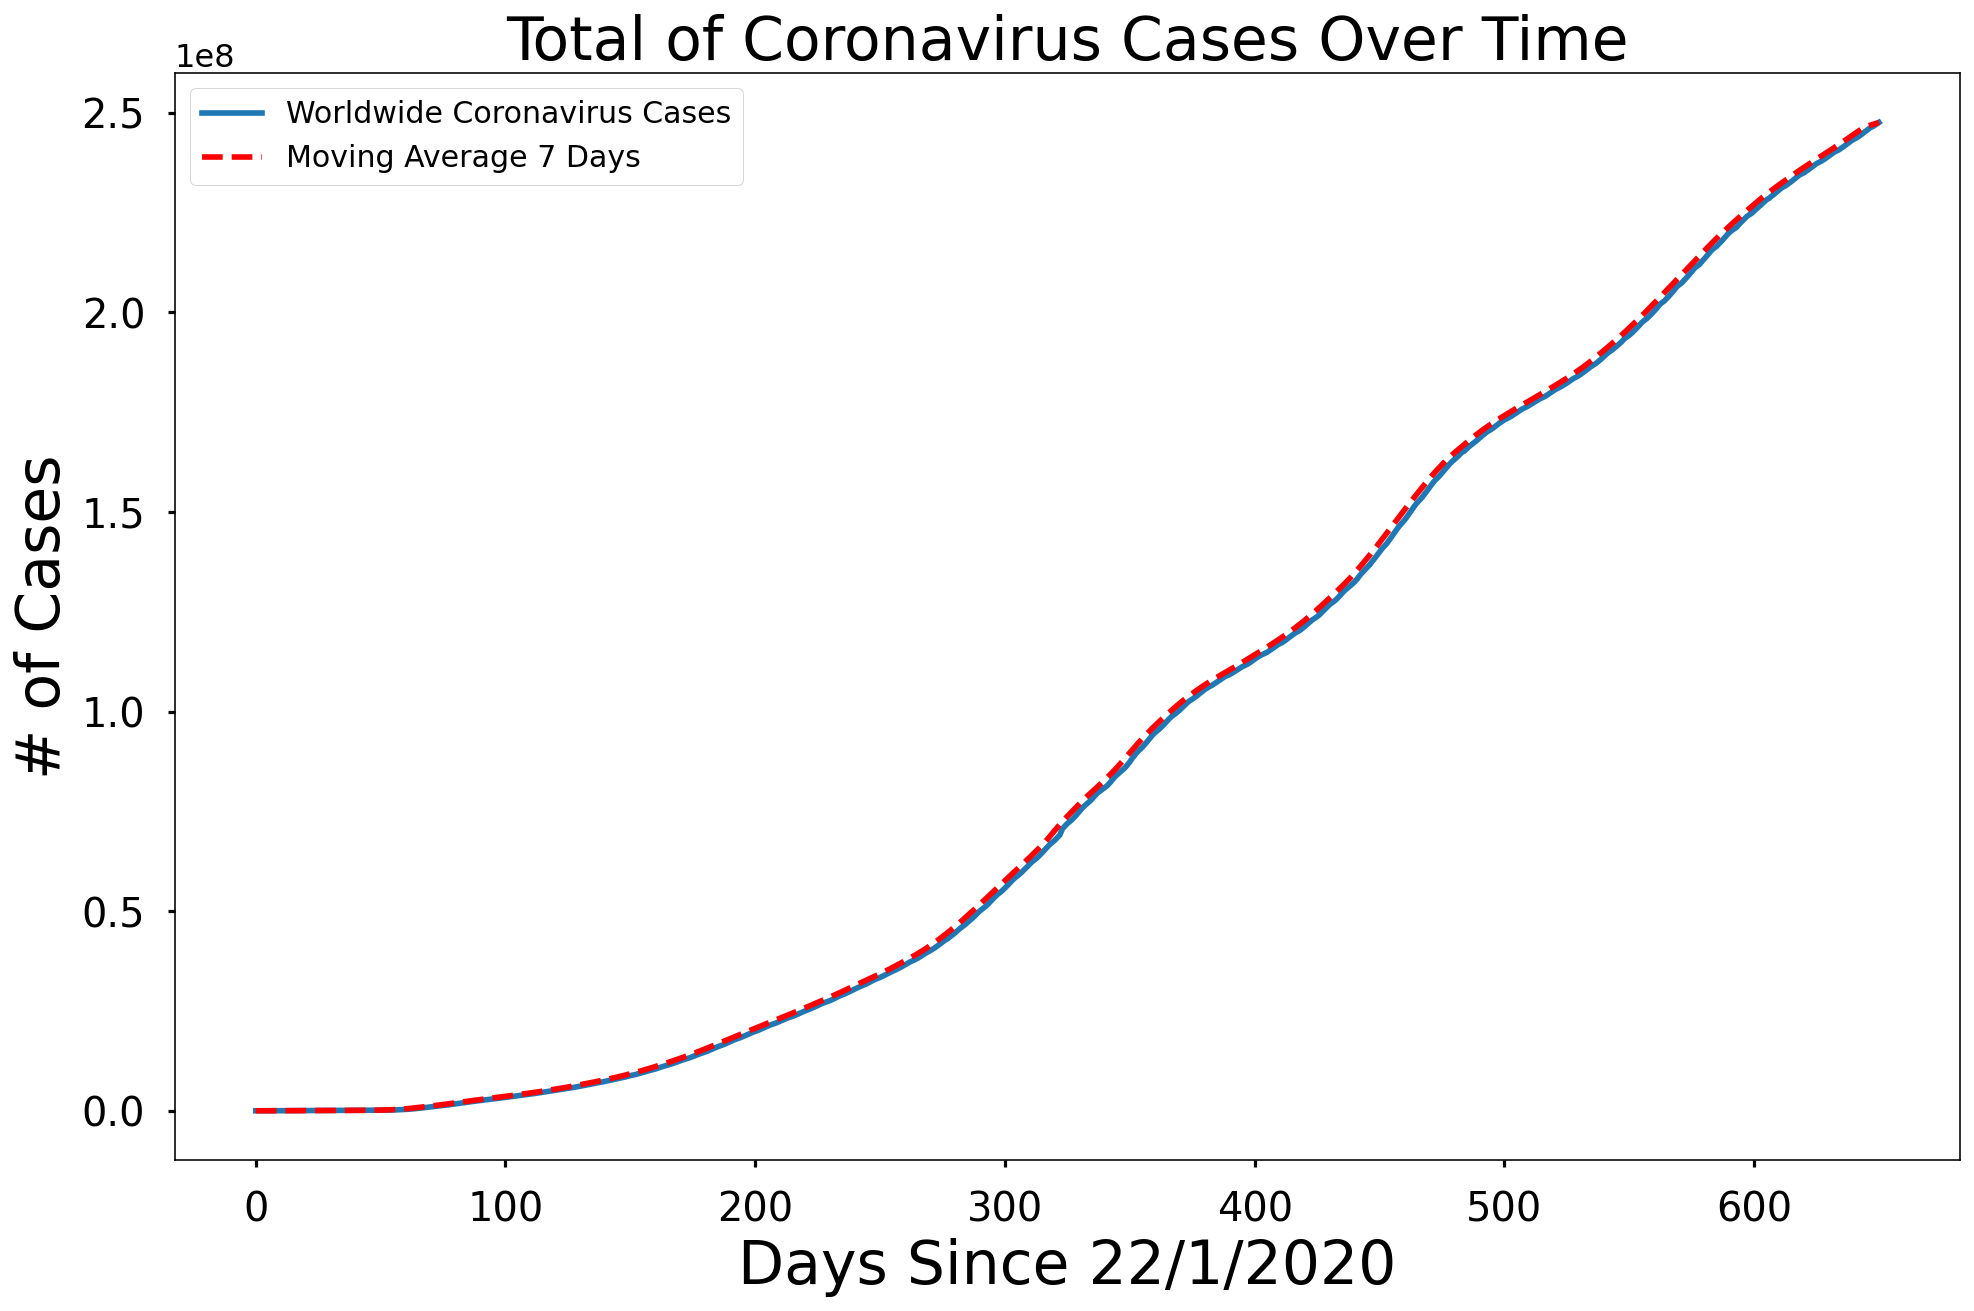

In [9]:
plt.figure(figsize=PLOT_SIZE)
plt.plot(num_of_days, world_cases)
plt.plot(num_of_days, world_confirmed_avg, linestyle='dashed', color='red')
plt.title('Total of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 22/1/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Worldwide Coronavirus Cases', 'Moving Average {} Days'.format(window)], prop={'size': 15})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

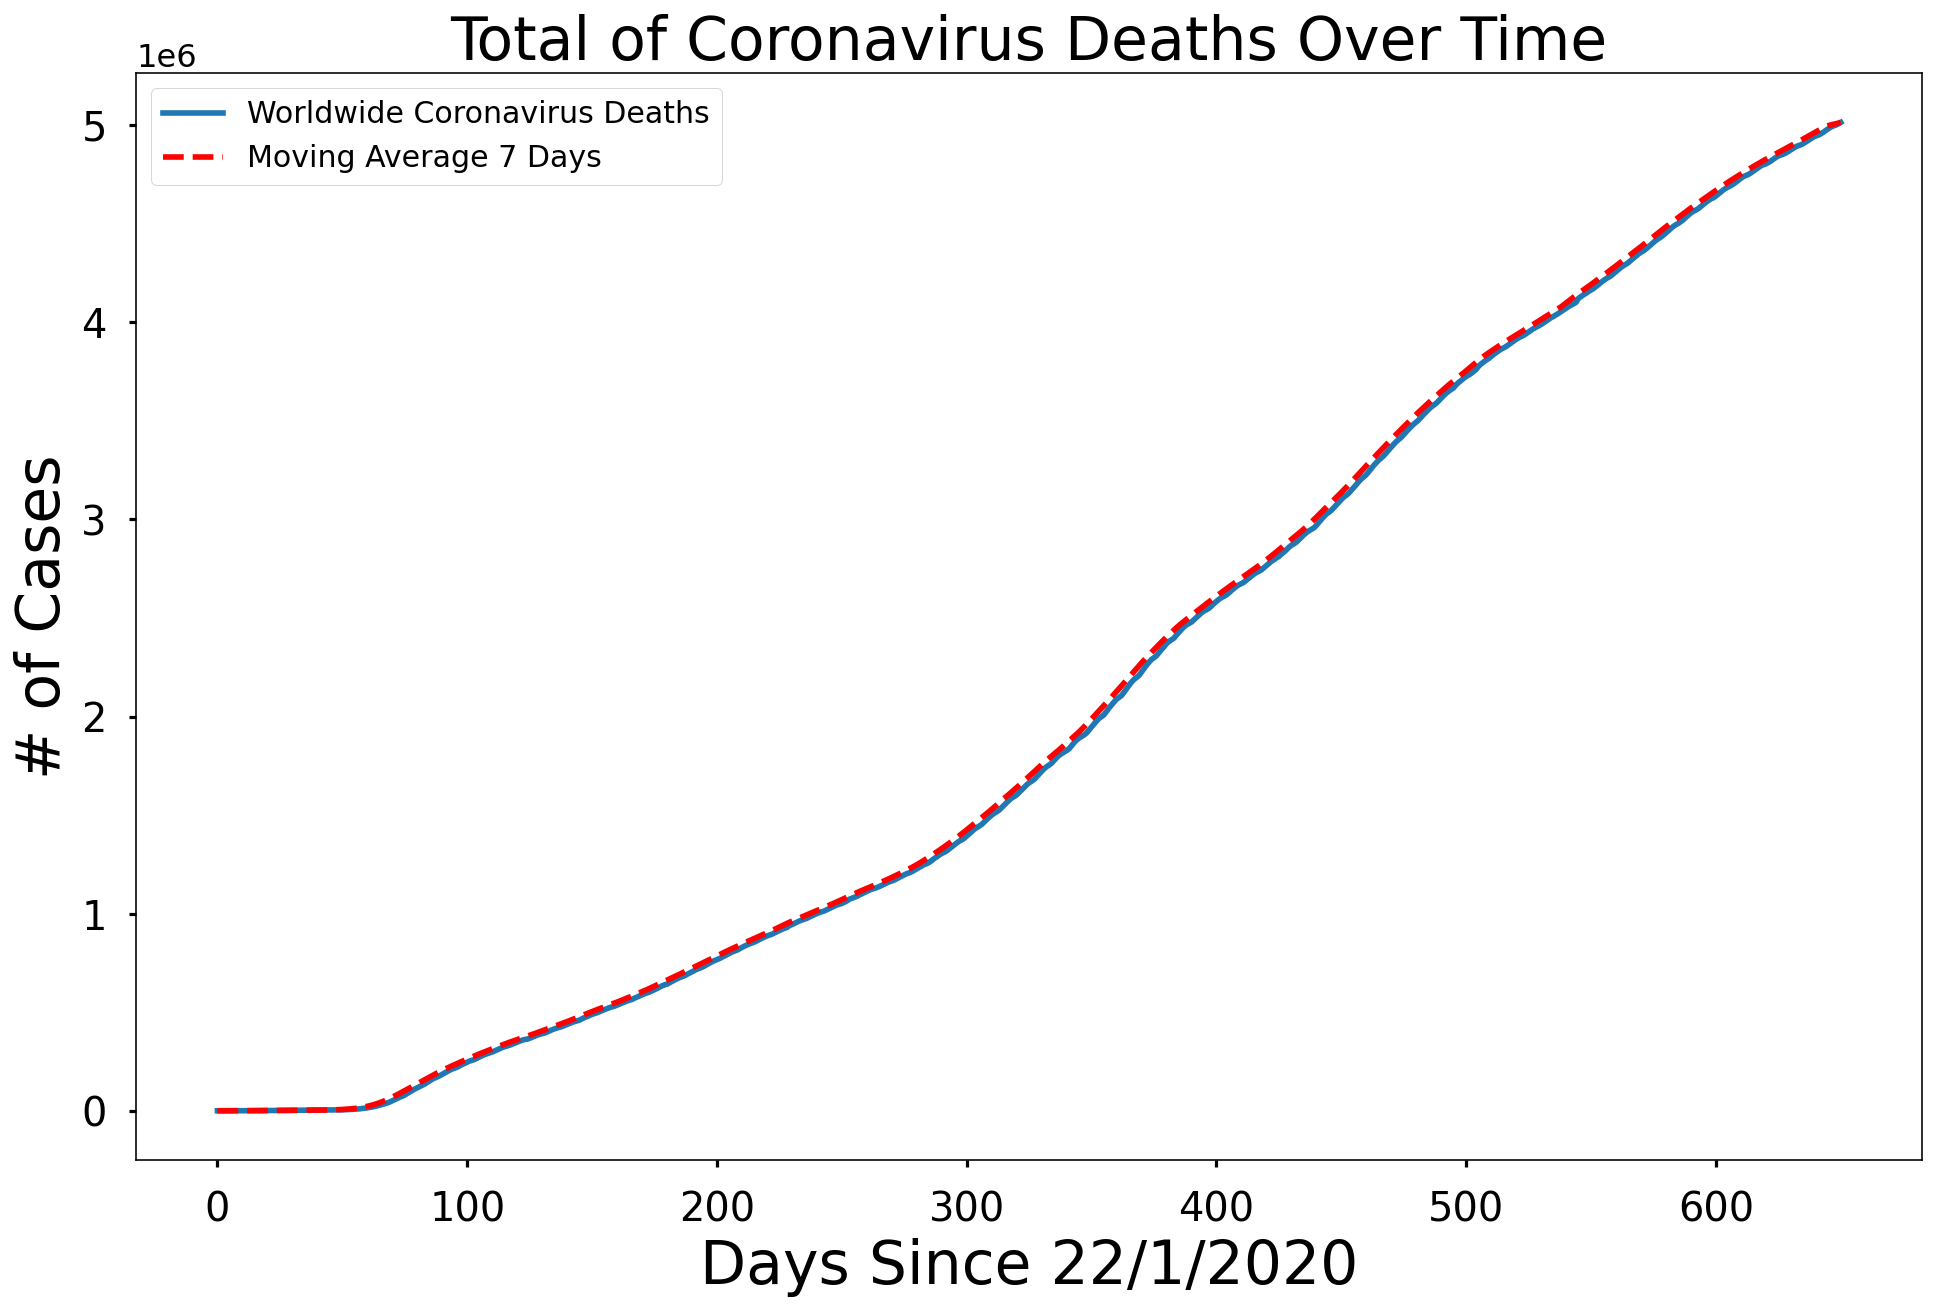

In [10]:
plt.figure(figsize=PLOT_SIZE)
plt.plot(num_of_days, total_deaths)
plt.plot(num_of_days, world_death_avg, linestyle='dashed', color='red')
plt.title('Total of Coronavirus Deaths Over Time', size=30)
plt.xlabel('Days Since 22/1/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Worldwide Coronavirus Deaths', 'Moving Average {} Days'.format(window)], prop={'size': 15})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

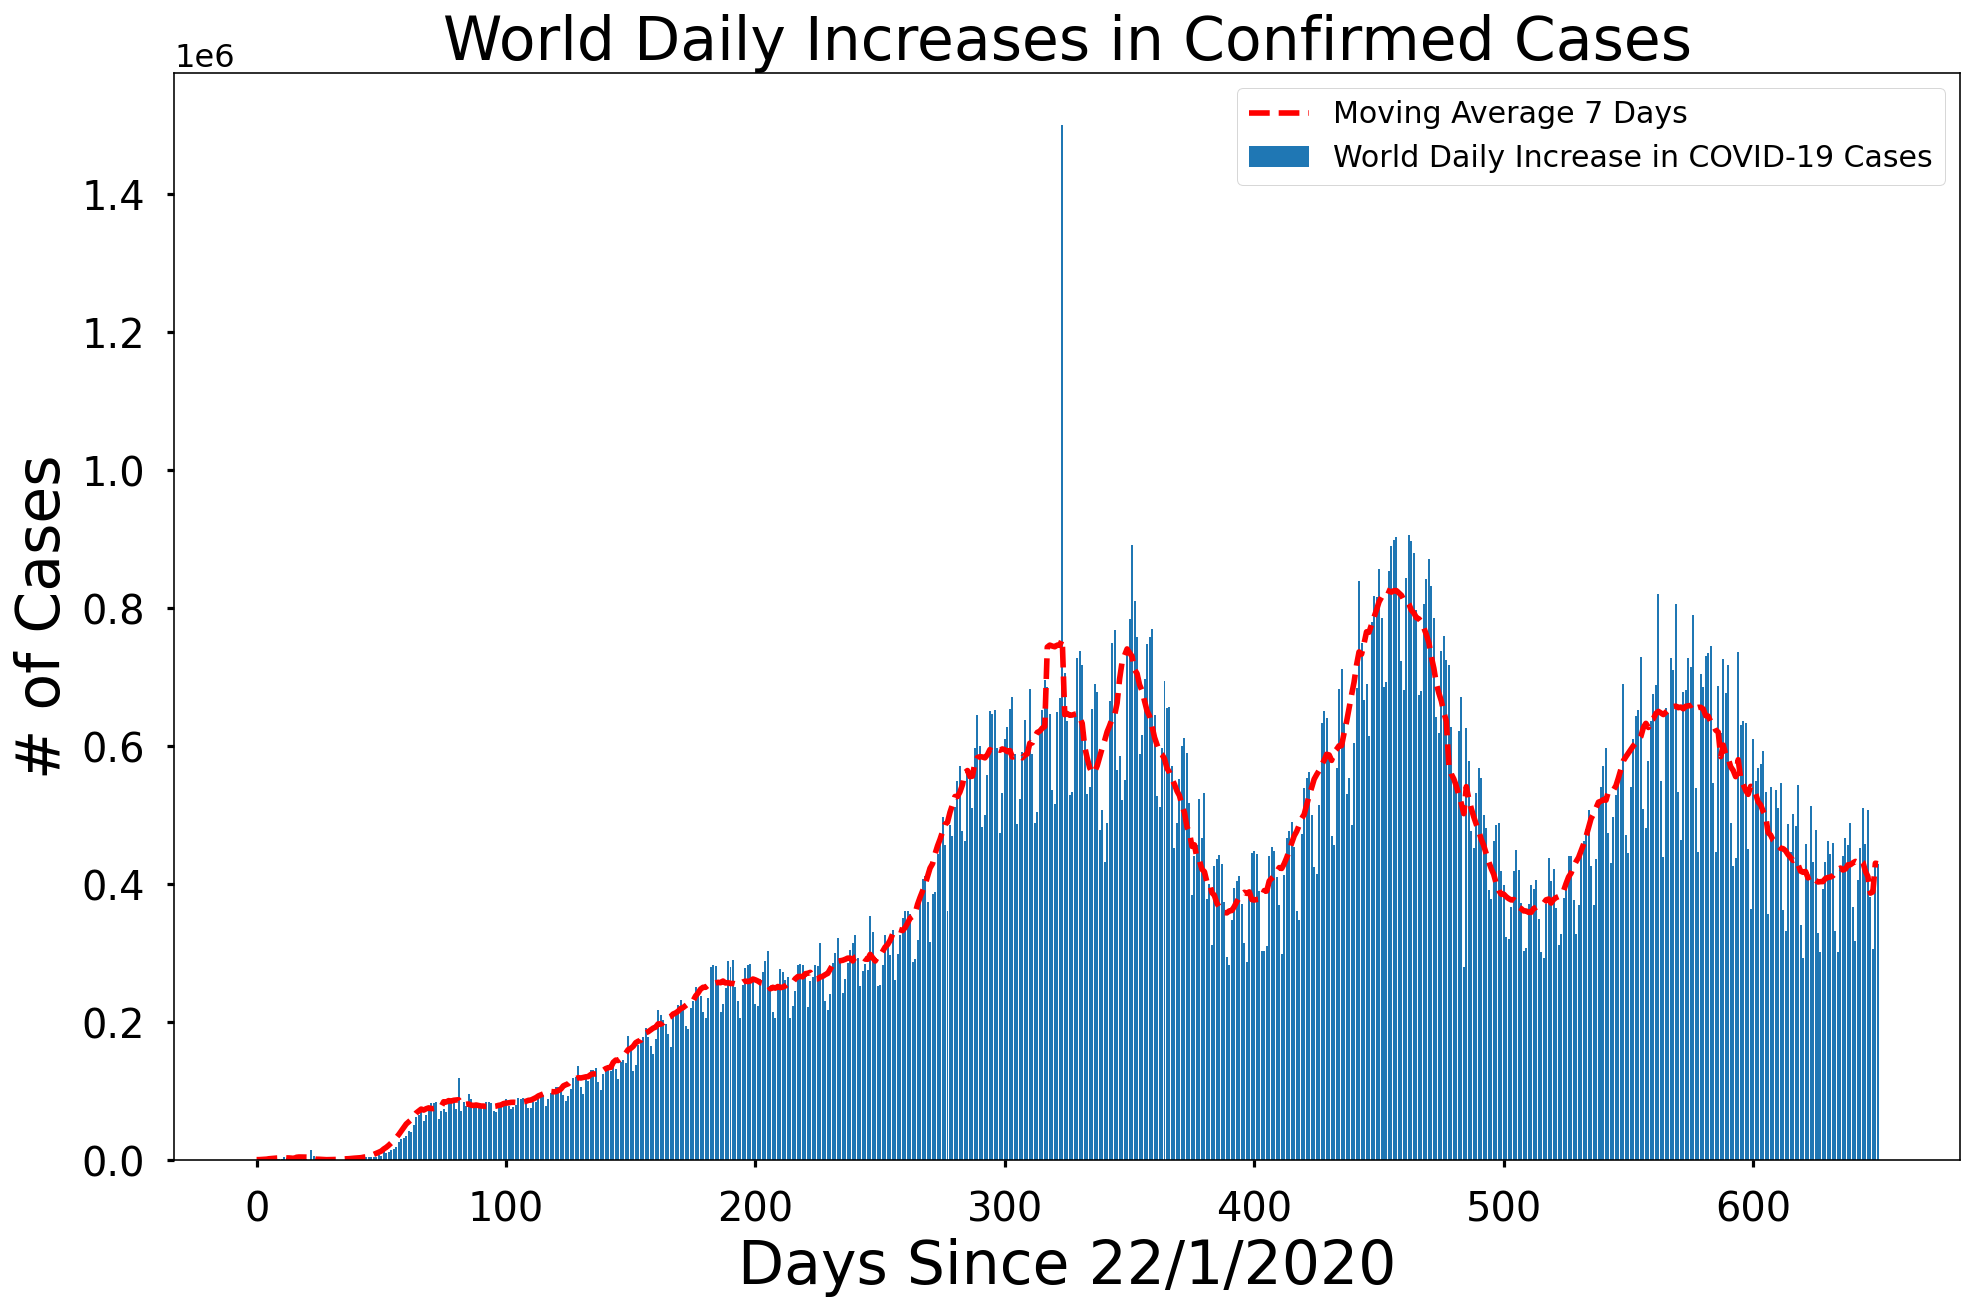

In [11]:
plt.figure(figsize=PLOT_SIZE)
plt.bar(num_of_days, world_daily_increase)
plt.plot(num_of_days, world_daily_increase_avg, color='red', linestyle='dashed')
plt.title('World Daily Increases in Confirmed Cases', size=30)
plt.xlabel('Days Since 22/1/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Moving Average {} Days'.format(window), 'World Daily Increase in COVID-19 Cases'], prop={'size': 15})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

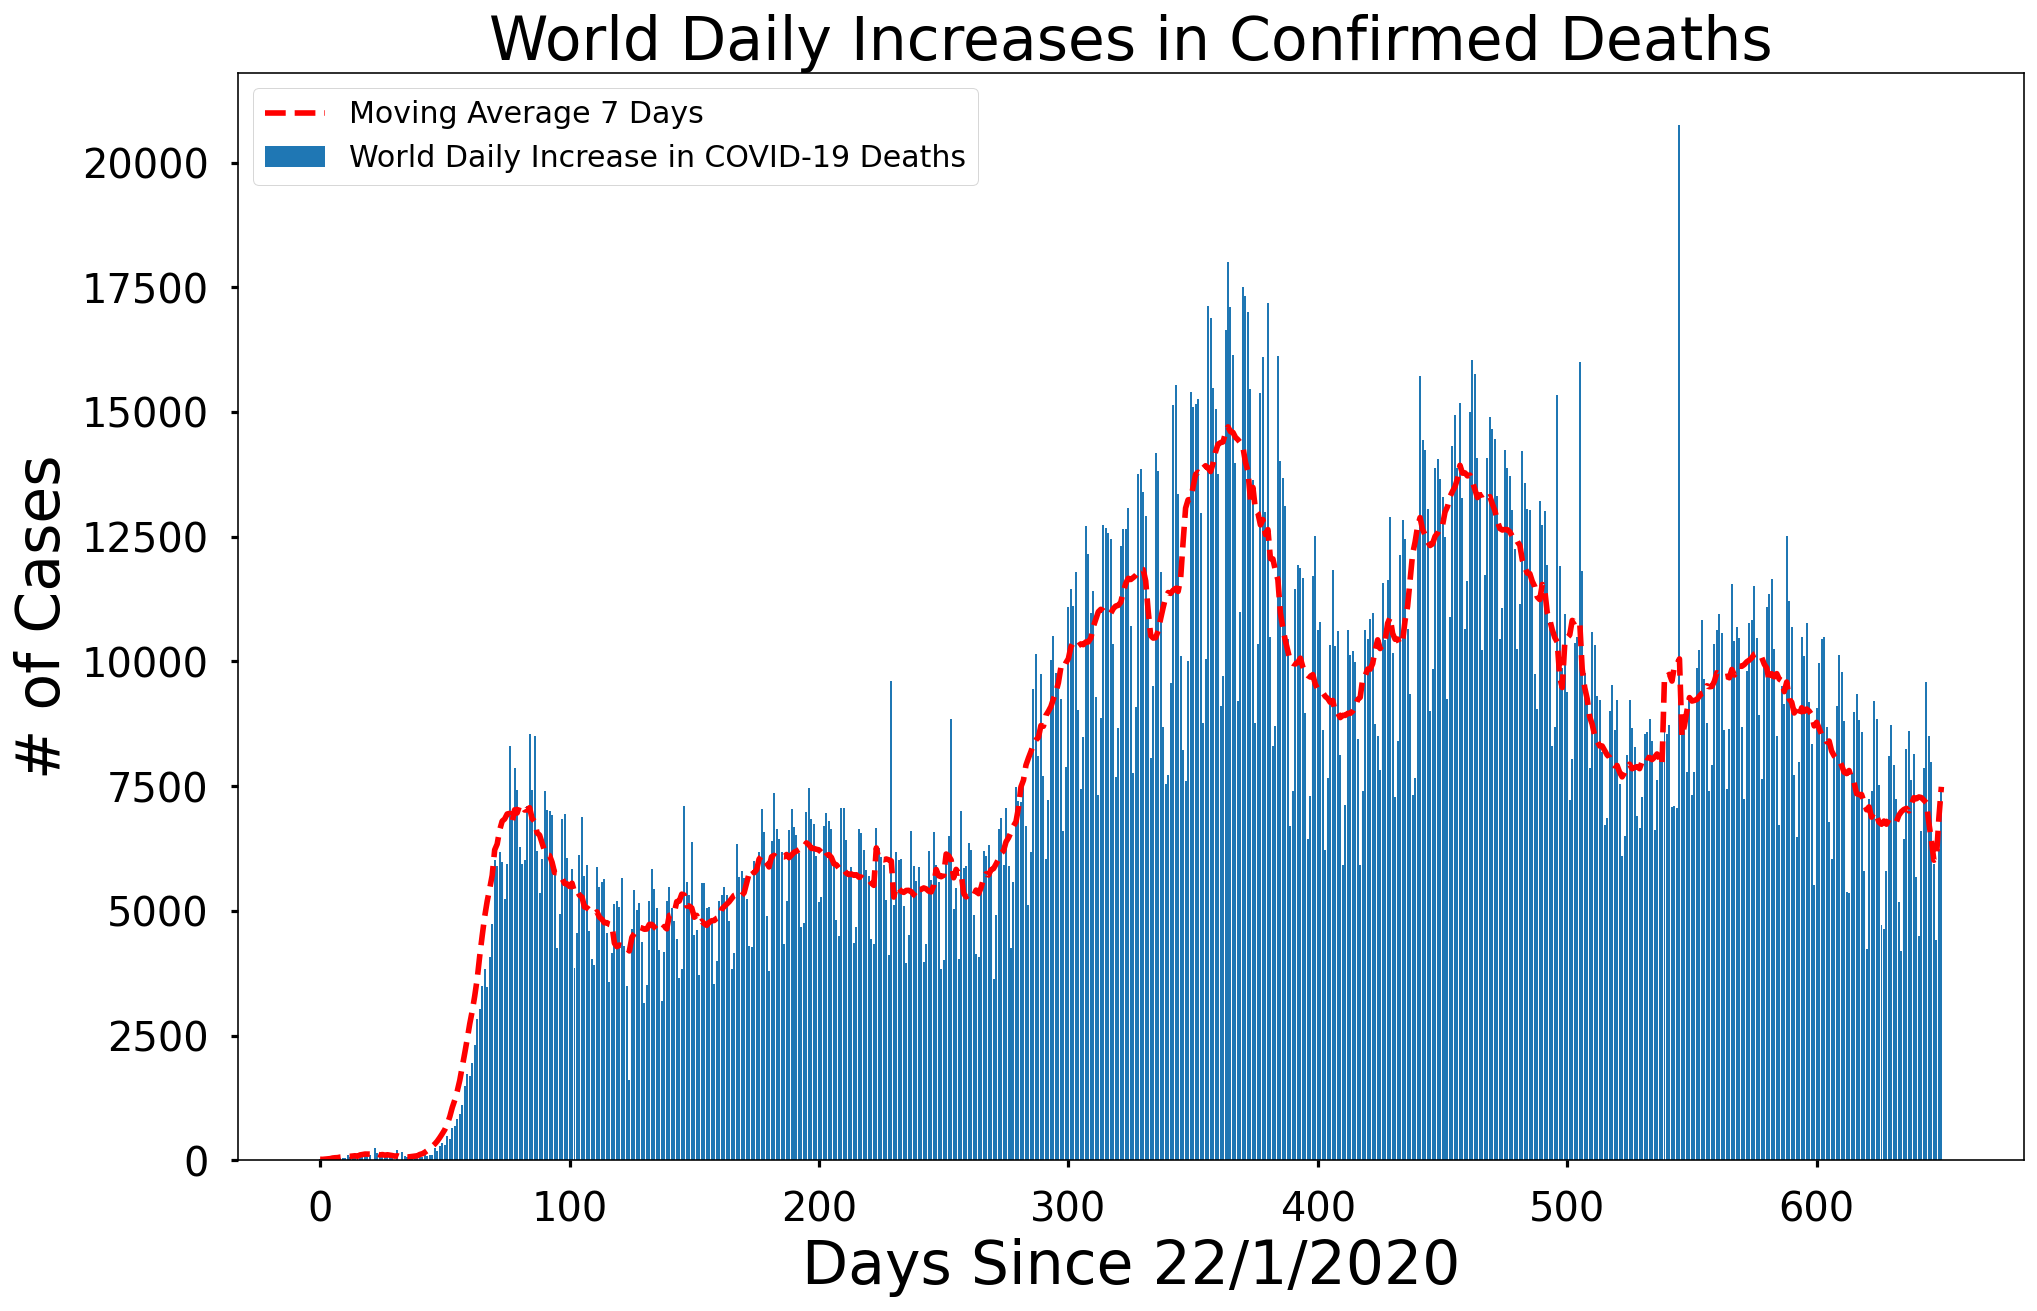

In [12]:
plt.figure(figsize=PLOT_SIZE)
plt.bar(num_of_days, world_daily_death)
plt.plot(num_of_days, world_daily_death_avg, color='red', linestyle='dashed')
plt.title('World Daily Increases in Confirmed Deaths', size=30)
plt.xlabel('Days Since 22/1/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Moving Average {} Days'.format(window), 'World Daily Increase in COVID-19 Deaths'], prop={'size': 15})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

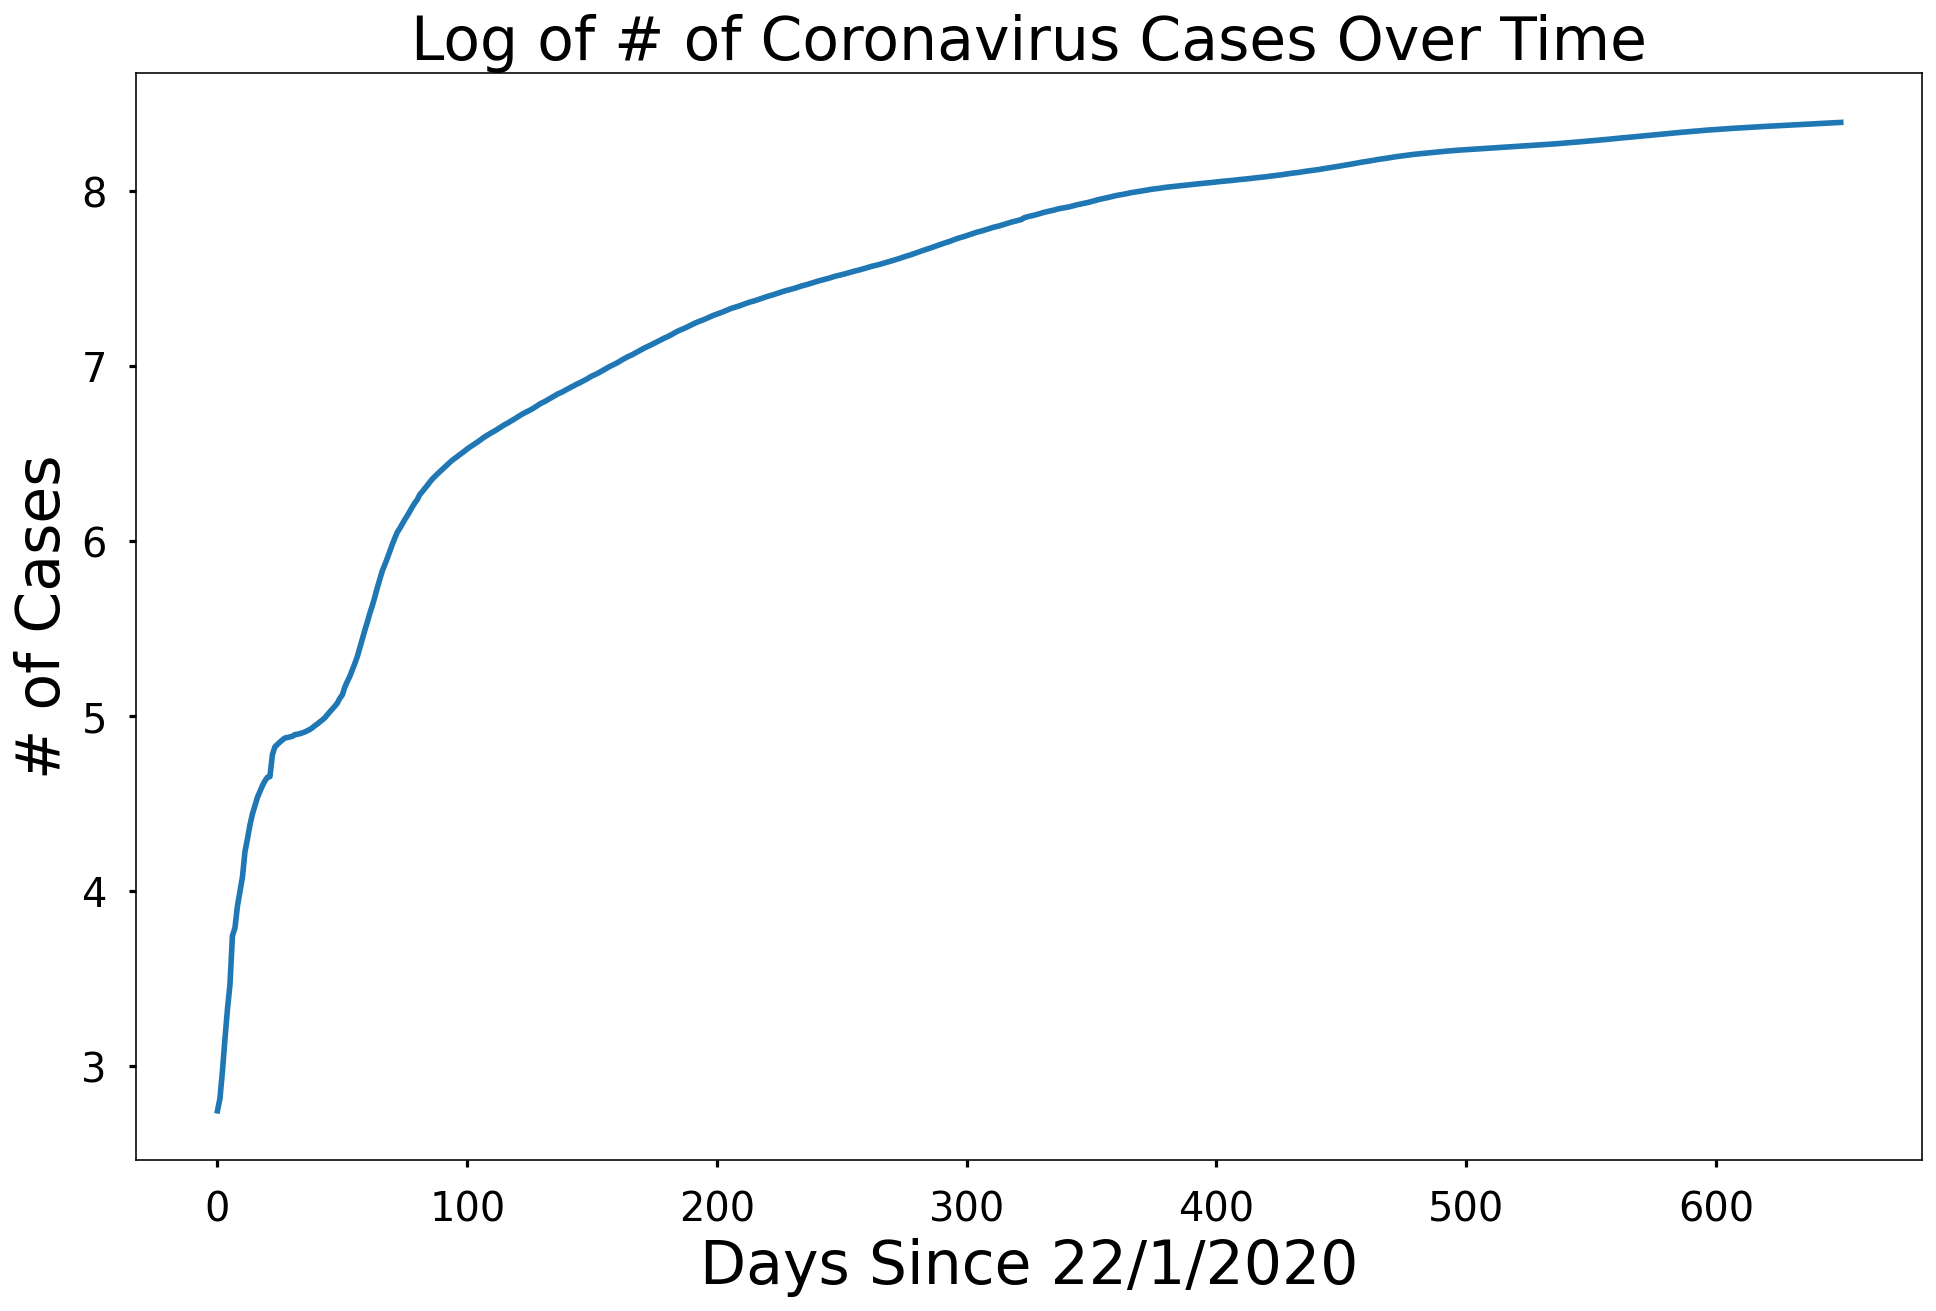

In [13]:
plt.figure(figsize=PLOT_SIZE)
plt.plot(num_of_days, np.log10(world_cases))
plt.title('Log of # of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 22/1/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

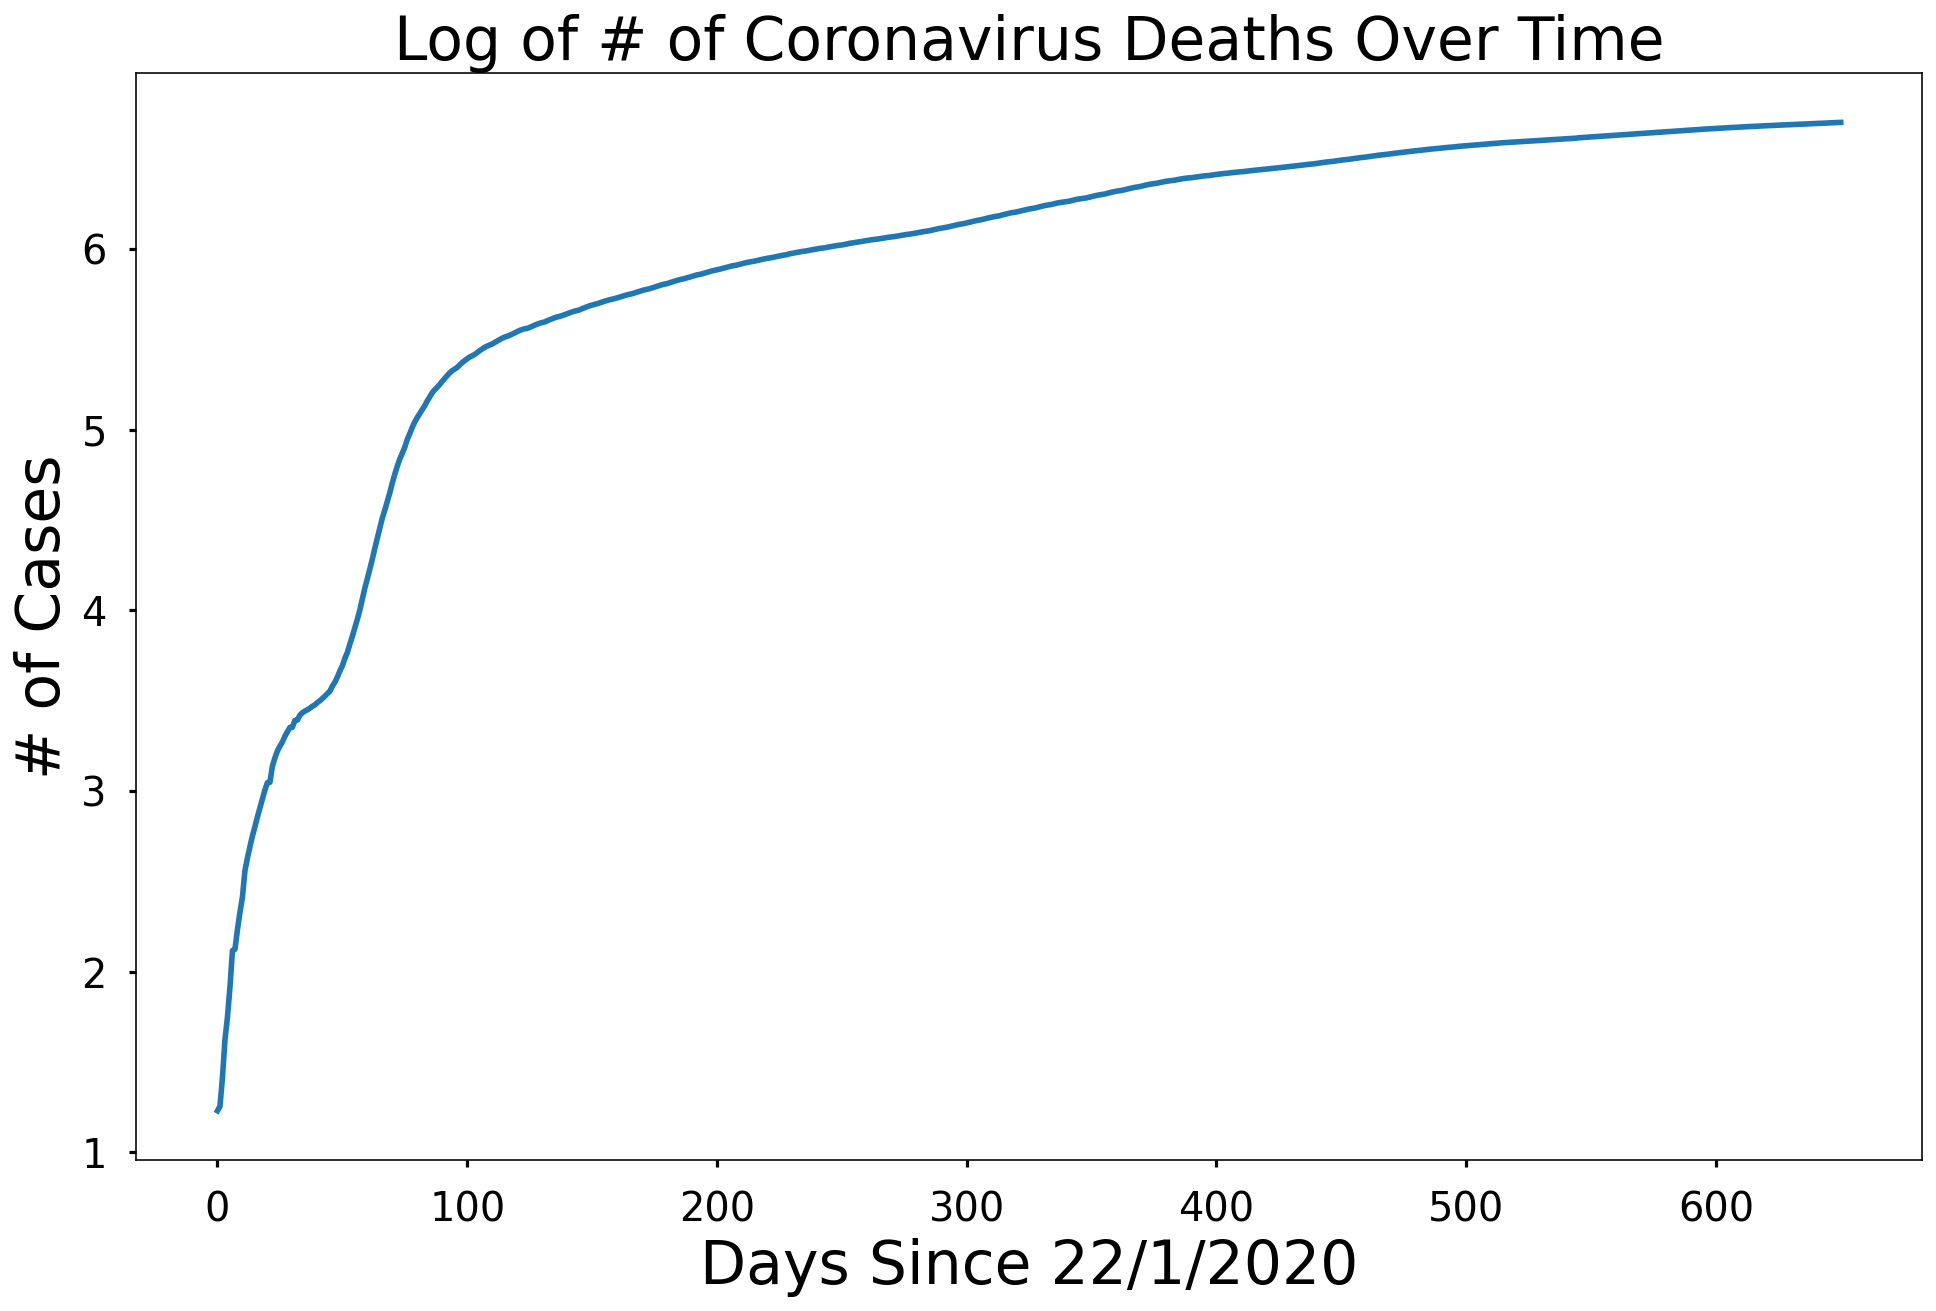

In [14]:
plt.figure(figsize=PLOT_SIZE)
plt.plot(num_of_days, np.log10(total_deaths))
plt.title('Log of # of Coronavirus Deaths Over Time', size=30)
plt.xlabel('Days Since 22/1/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [15]:
def country_plot(x, y1, y2, y3, country):
    # window is set as 14 in in the beginning of the notebook 
    confirmed_avg = moving_average(y1, window)
    confirmed_increase_avg = moving_average(y2, window)
    death_increase_avg = moving_average(y3, window)

    plt.figure(figsize=PLOT_SIZE)
    plt.plot(x, y1)
    plt.plot(x, confirmed_avg, color='red', linestyle='dashed')
    plt.legend(['{} Confirmed Cases'.format(country), 'Moving Average {} Days'.format(window)], prop={'size': 20})
    plt.title('{} Confirmed Cases'.format(country), size=30)
    plt.xlabel('Days Since 22/1/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

    plt.figure(figsize=PLOT_SIZE)
    plt.bar(x, y2)
    plt.plot(x, confirmed_increase_avg, color='red', linestyle='dashed')
    plt.legend(['Moving Average {} Days'.format(window), '{} Daily Increase in Confirmed Cases'.format(country)], prop={'size': 20})
    plt.title('{} Daily Increases in Confirmed Cases'.format(country), size=30)
    plt.xlabel('Days Since 22/1/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

    plt.figure(figsize=PLOT_SIZE)
    plt.bar(x, y3)
    plt.plot(x, death_increase_avg, color='red', linestyle='dashed')
    plt.legend(['Moving Average {} Days'.format(window), '{} Daily Increase in Confirmed Deaths'.format(country)], prop={'size': 20})
    plt.title('{} Daily Increases in Deaths'.format(country), size=30)
    plt.xlabel('Days Since 22/1/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

In [16]:
# helper function for getting country's cases, deaths, and recoveries        
def get_country_info(country_name):
    country_cases = []
    country_deaths = []
    for i in dates:
        country_cases.append(confirmed_df[confirmed_df['Country/Region']==country_name][i].sum())
        country_deaths.append(deaths_df[deaths_df['Country/Region']==country_name][i].sum())
    return (country_cases, country_deaths)

In [17]:
def country_visualizations(country_name):
    country_info = get_country_info(country_name)
    country_cases = country_info[0]
    country_deaths = country_info[1]
    
    country_daily_increase = daily_increase(country_cases)
    country_daily_death = daily_increase(country_deaths)
    country_plot(num_of_days, country_cases, country_daily_increase, country_daily_death, country_name)

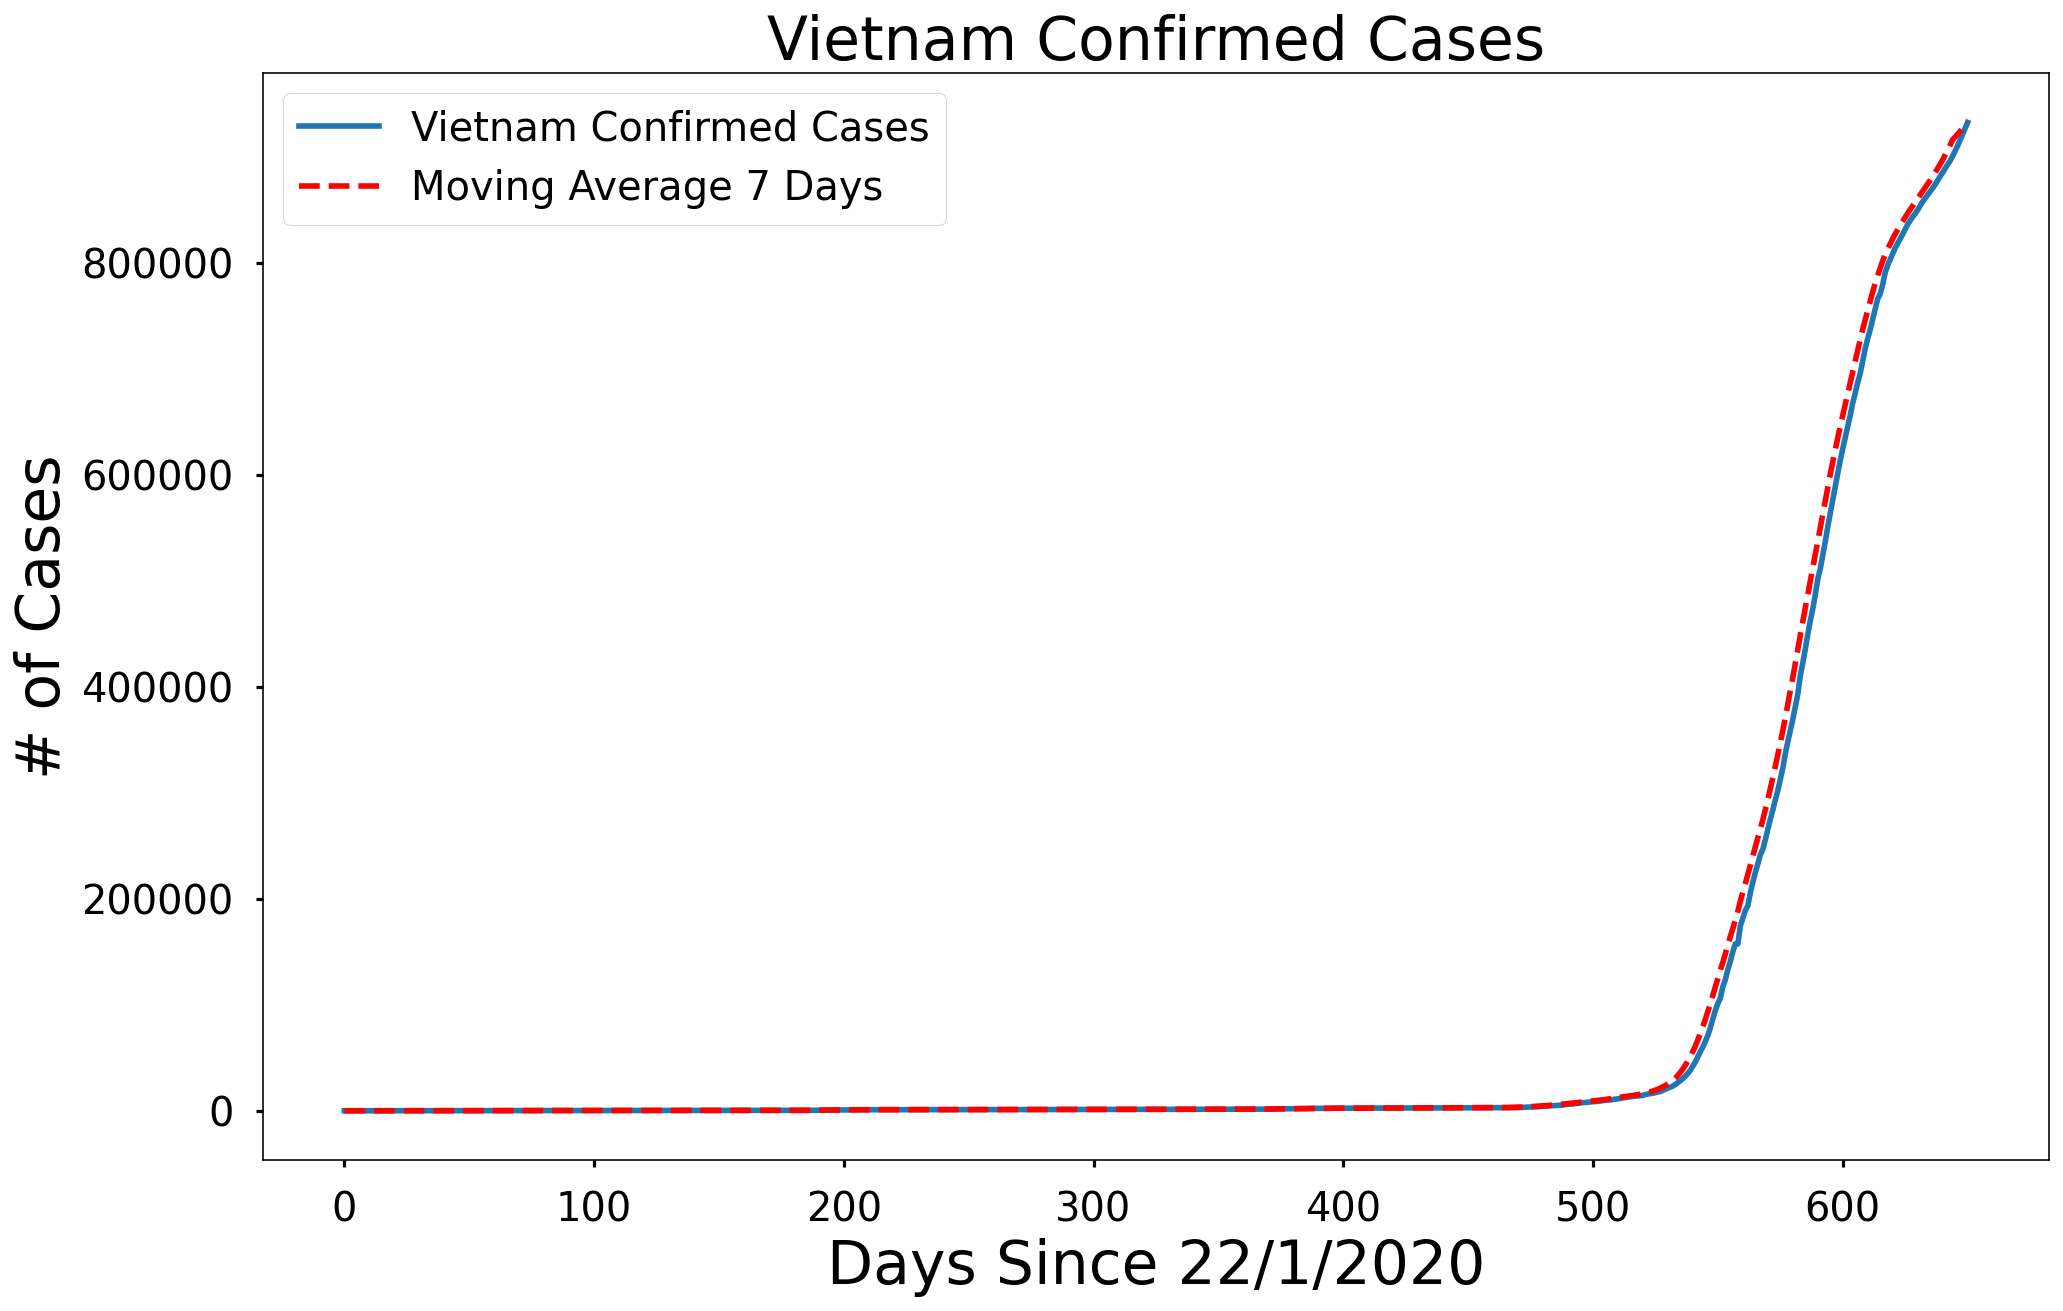

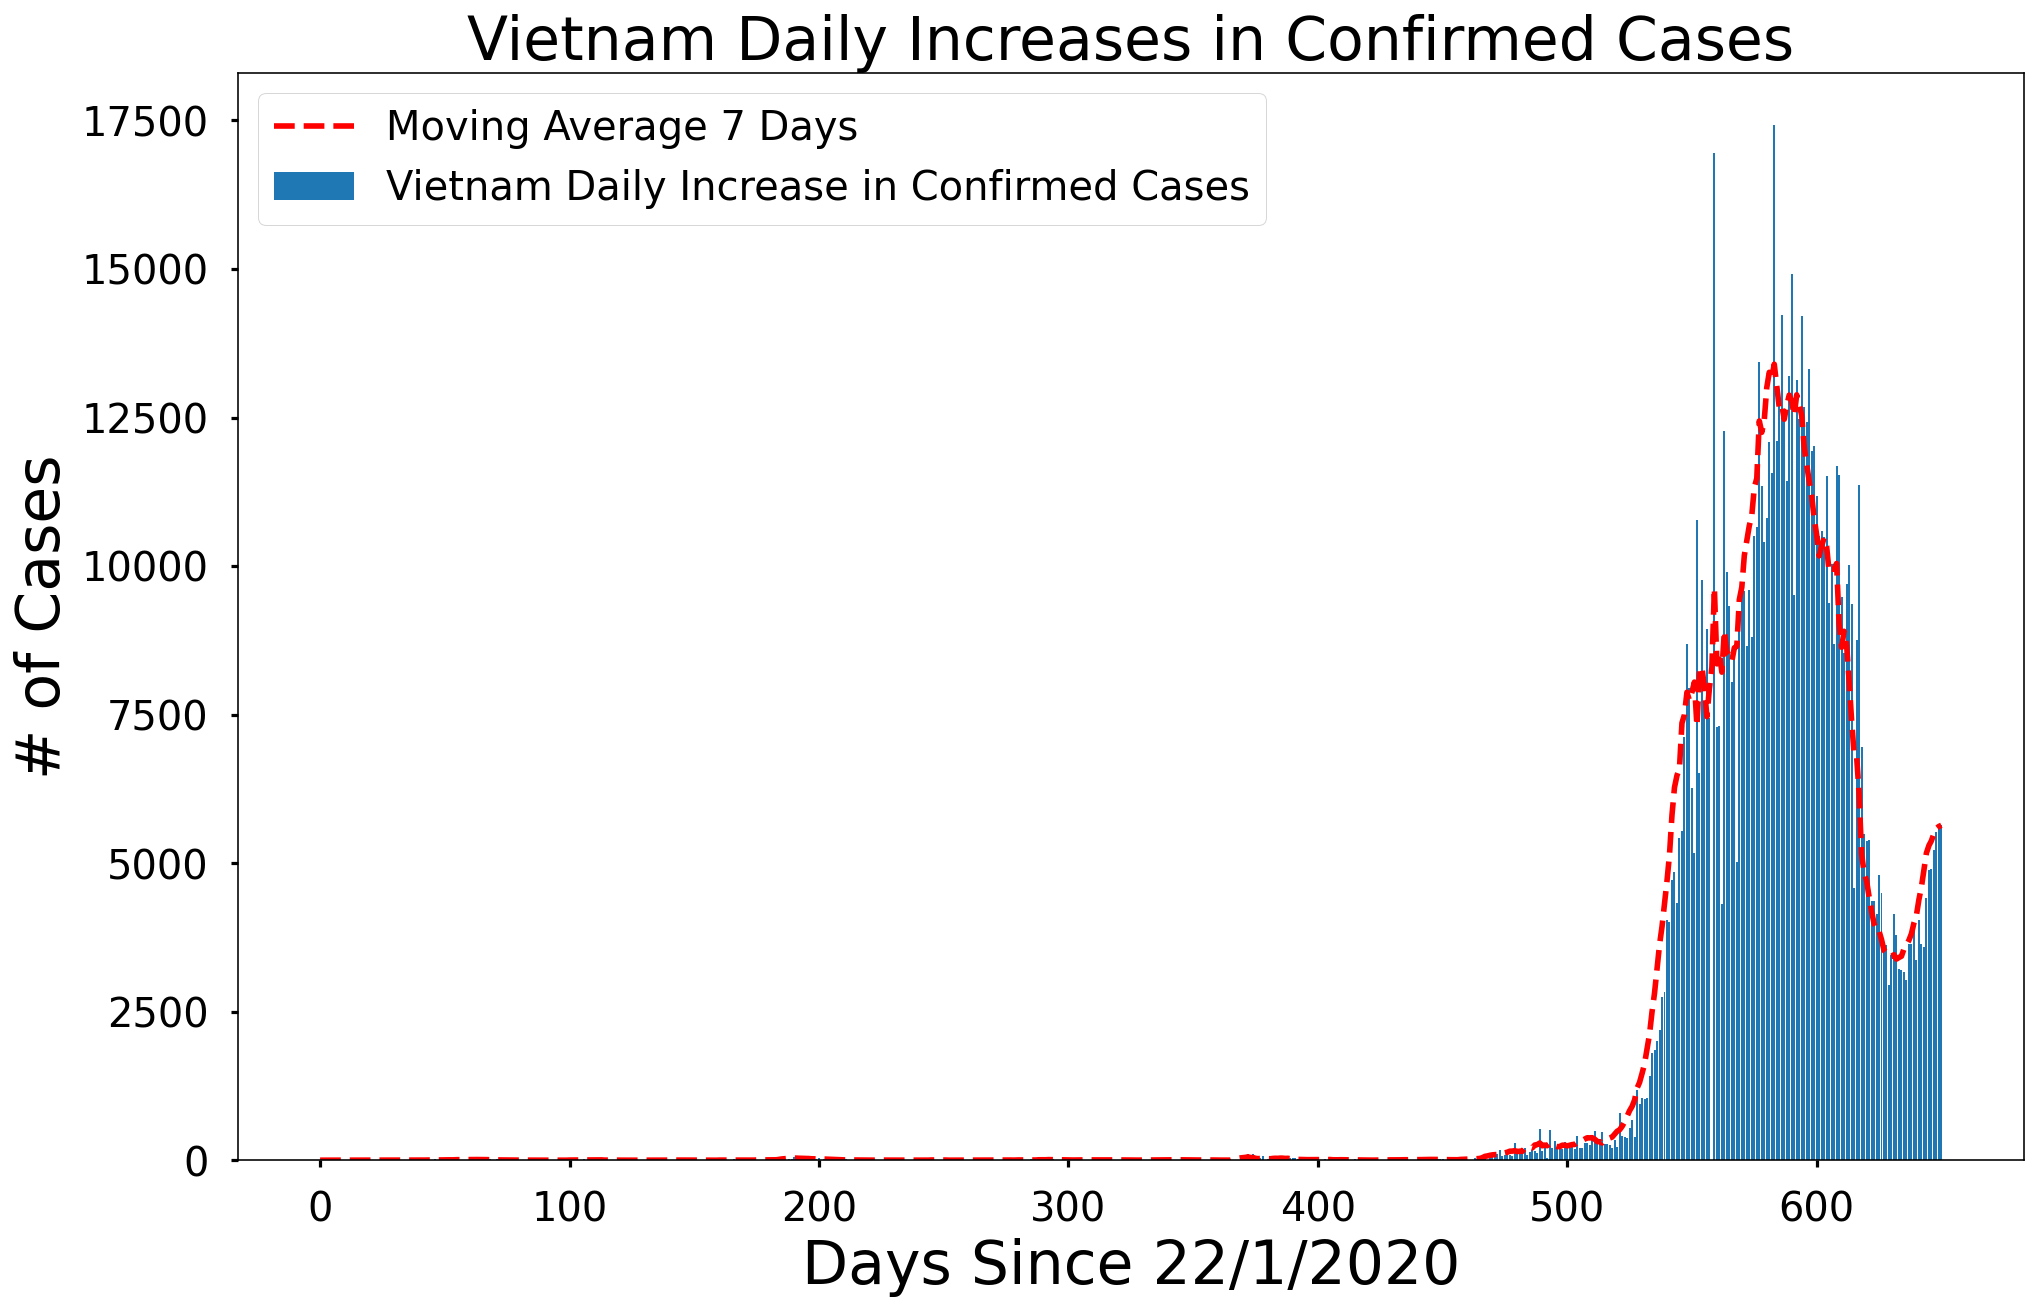

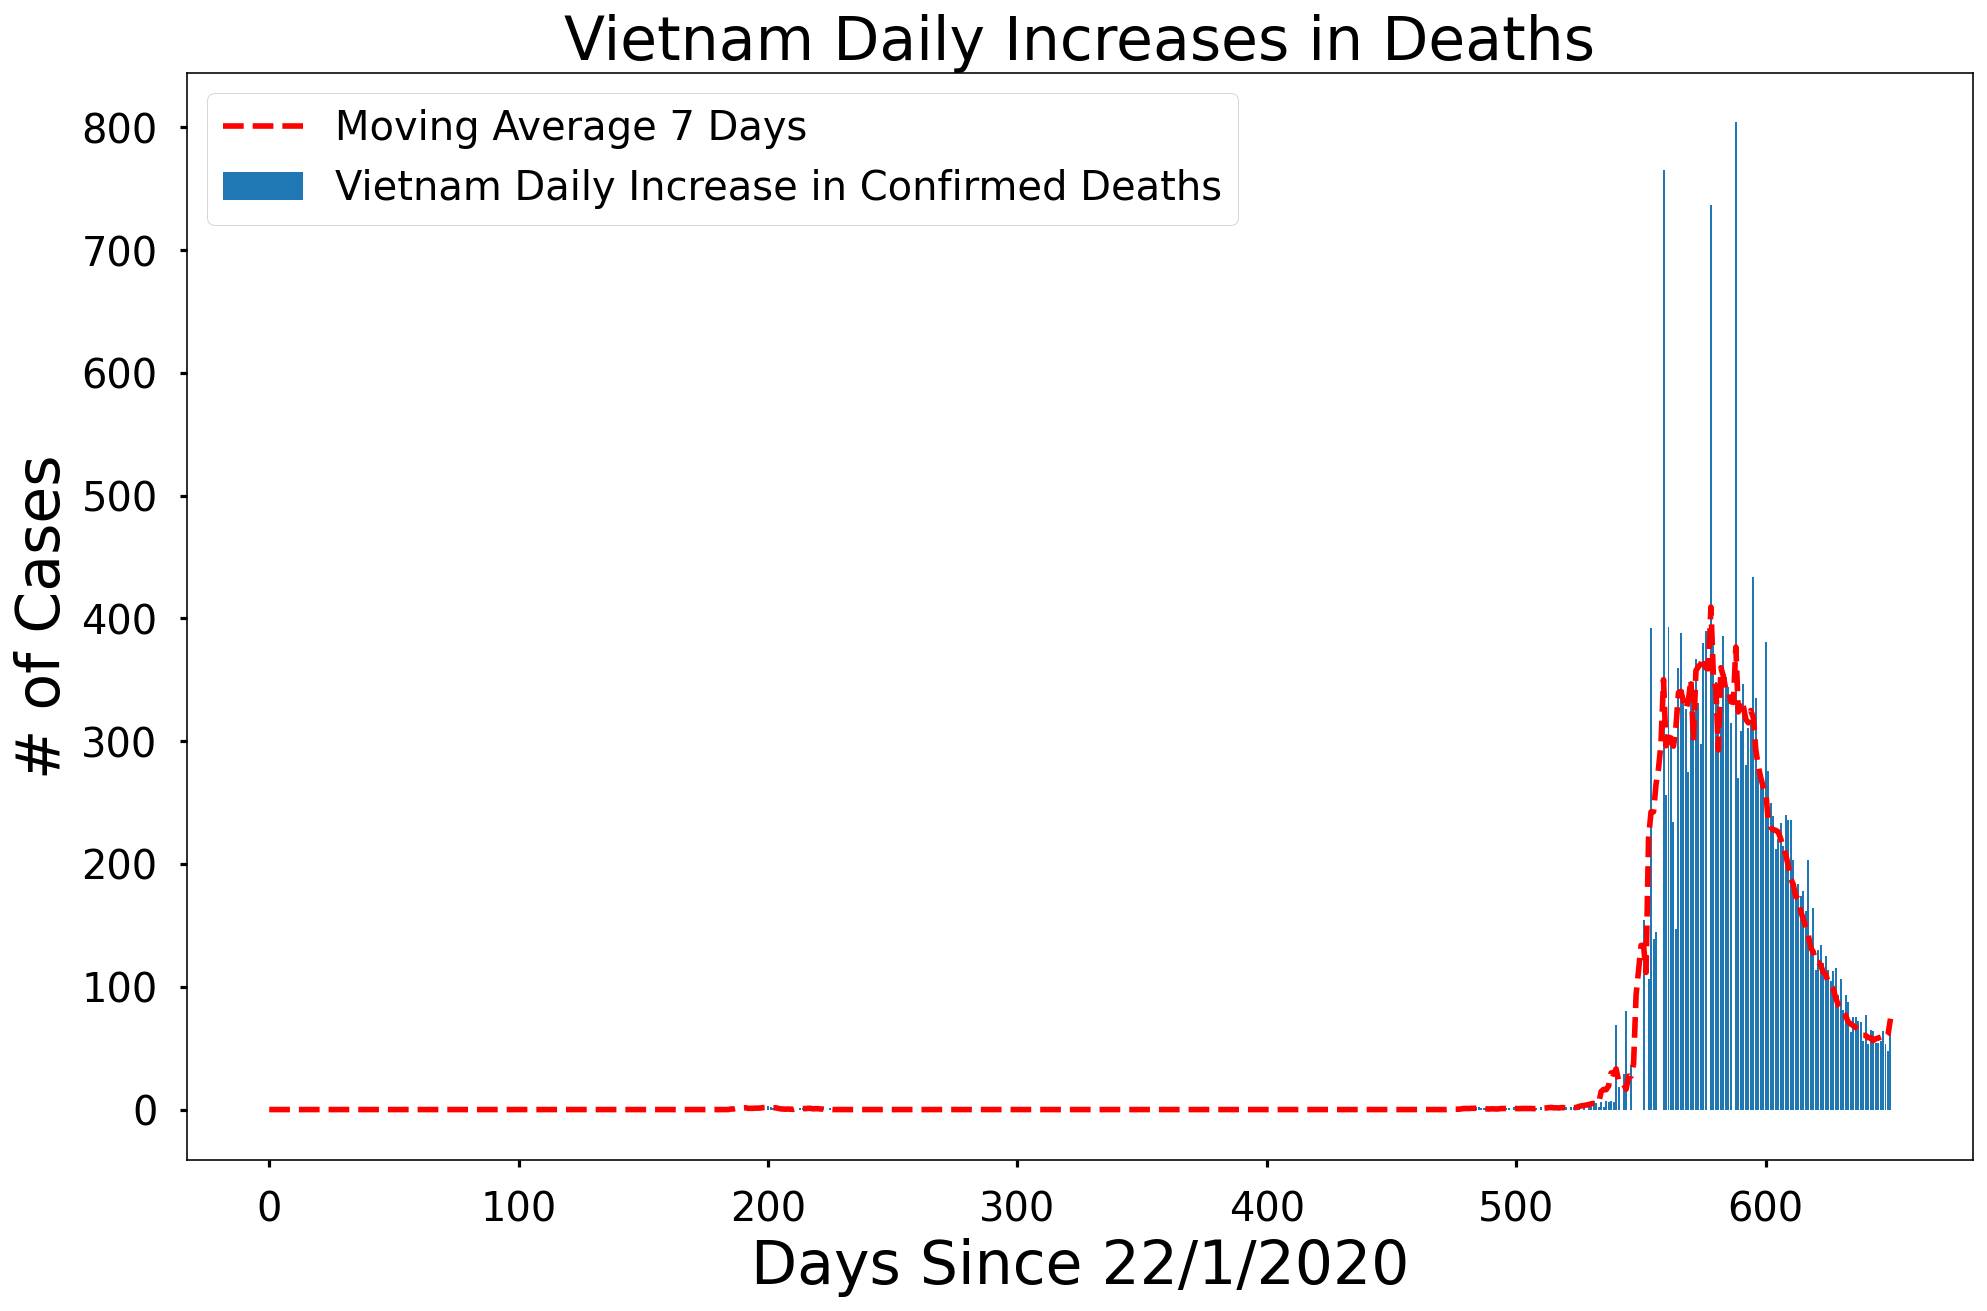

In [18]:
country = input('Which country do you want to see:')
country_visualizations(country)

In [19]:
unique_countries =  list(latest_data['Country_Region'].unique())
country_confirmed_cases = []
country_death_cases = [] 
country_active_cases = []
country_incidence_rate = [] 
country_mortality_rate = [] 
no_cases = []
for i in unique_countries:
    cases = latest_data[latest_data['Country_Region']==i]['Confirmed'].sum()
    if cases > 0:
        country_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
        
for i in no_cases:
    unique_countries.remove(i)
    
# sort countries by the number of confirmed cases
unique_countries = [k for k, v in sorted(zip(unique_countries, country_confirmed_cases), key=operator.itemgetter(1), reverse=True)]
for i in range(len(unique_countries)):
    country_confirmed_cases[i] = latest_data[latest_data['Country_Region']==unique_countries[i]]['Confirmed'].sum()
    country_death_cases.append(latest_data[latest_data['Country_Region']==unique_countries[i]]['Deaths'].sum())
    country_incidence_rate.append(latest_data[latest_data['Country_Region']==unique_countries[i]]['Incident_Rate'].sum())
    country_mortality_rate.append(country_death_cases[i]/country_confirmed_cases[i])


In [20]:
country_df = pd.DataFrame({'Country Name': unique_countries, 'Number of Confirmed Cases': [format(int(i), ',d') for i in country_confirmed_cases],
                          'Number of Deaths': [format(int(i), ',d') for i in country_death_cases], 
                          'Incidence Rate' : country_incidence_rate,
                          'Mortality Rate': country_mortality_rate})
                          
# number of cases per country/region
country_df.style.background_gradient(cmap='autumn_r')

,Country Name,Number of Confirmed Cases,Number of Deaths,Incidence Rate,Mortality Rate
0,US,"45,953,186","745,668",46967871.314968,0.016227
1,India,"34,273,300","458,186",149285.460654,0.013369
2,Brazil,"21,804,094","607,694",319293.960184,0.027871
3,United Kingdom,"9,062,710","140,981",128062.182068,0.015556
4,Russia,"8,338,053","233,063",471368.552089,0.027952
5,Turkey,"8,009,010","70,410",9496.204173,0.008791
6,France,"7,262,178","118,612",114821.218737,0.016333
7,Iran,"5,916,211","126,126",7043.699249,0.021319
8,Argentina,"5,288,259","115,942",11700.781248,0.021924
9,Spain,"5,011,148","87,368",196144.331202,0.017435


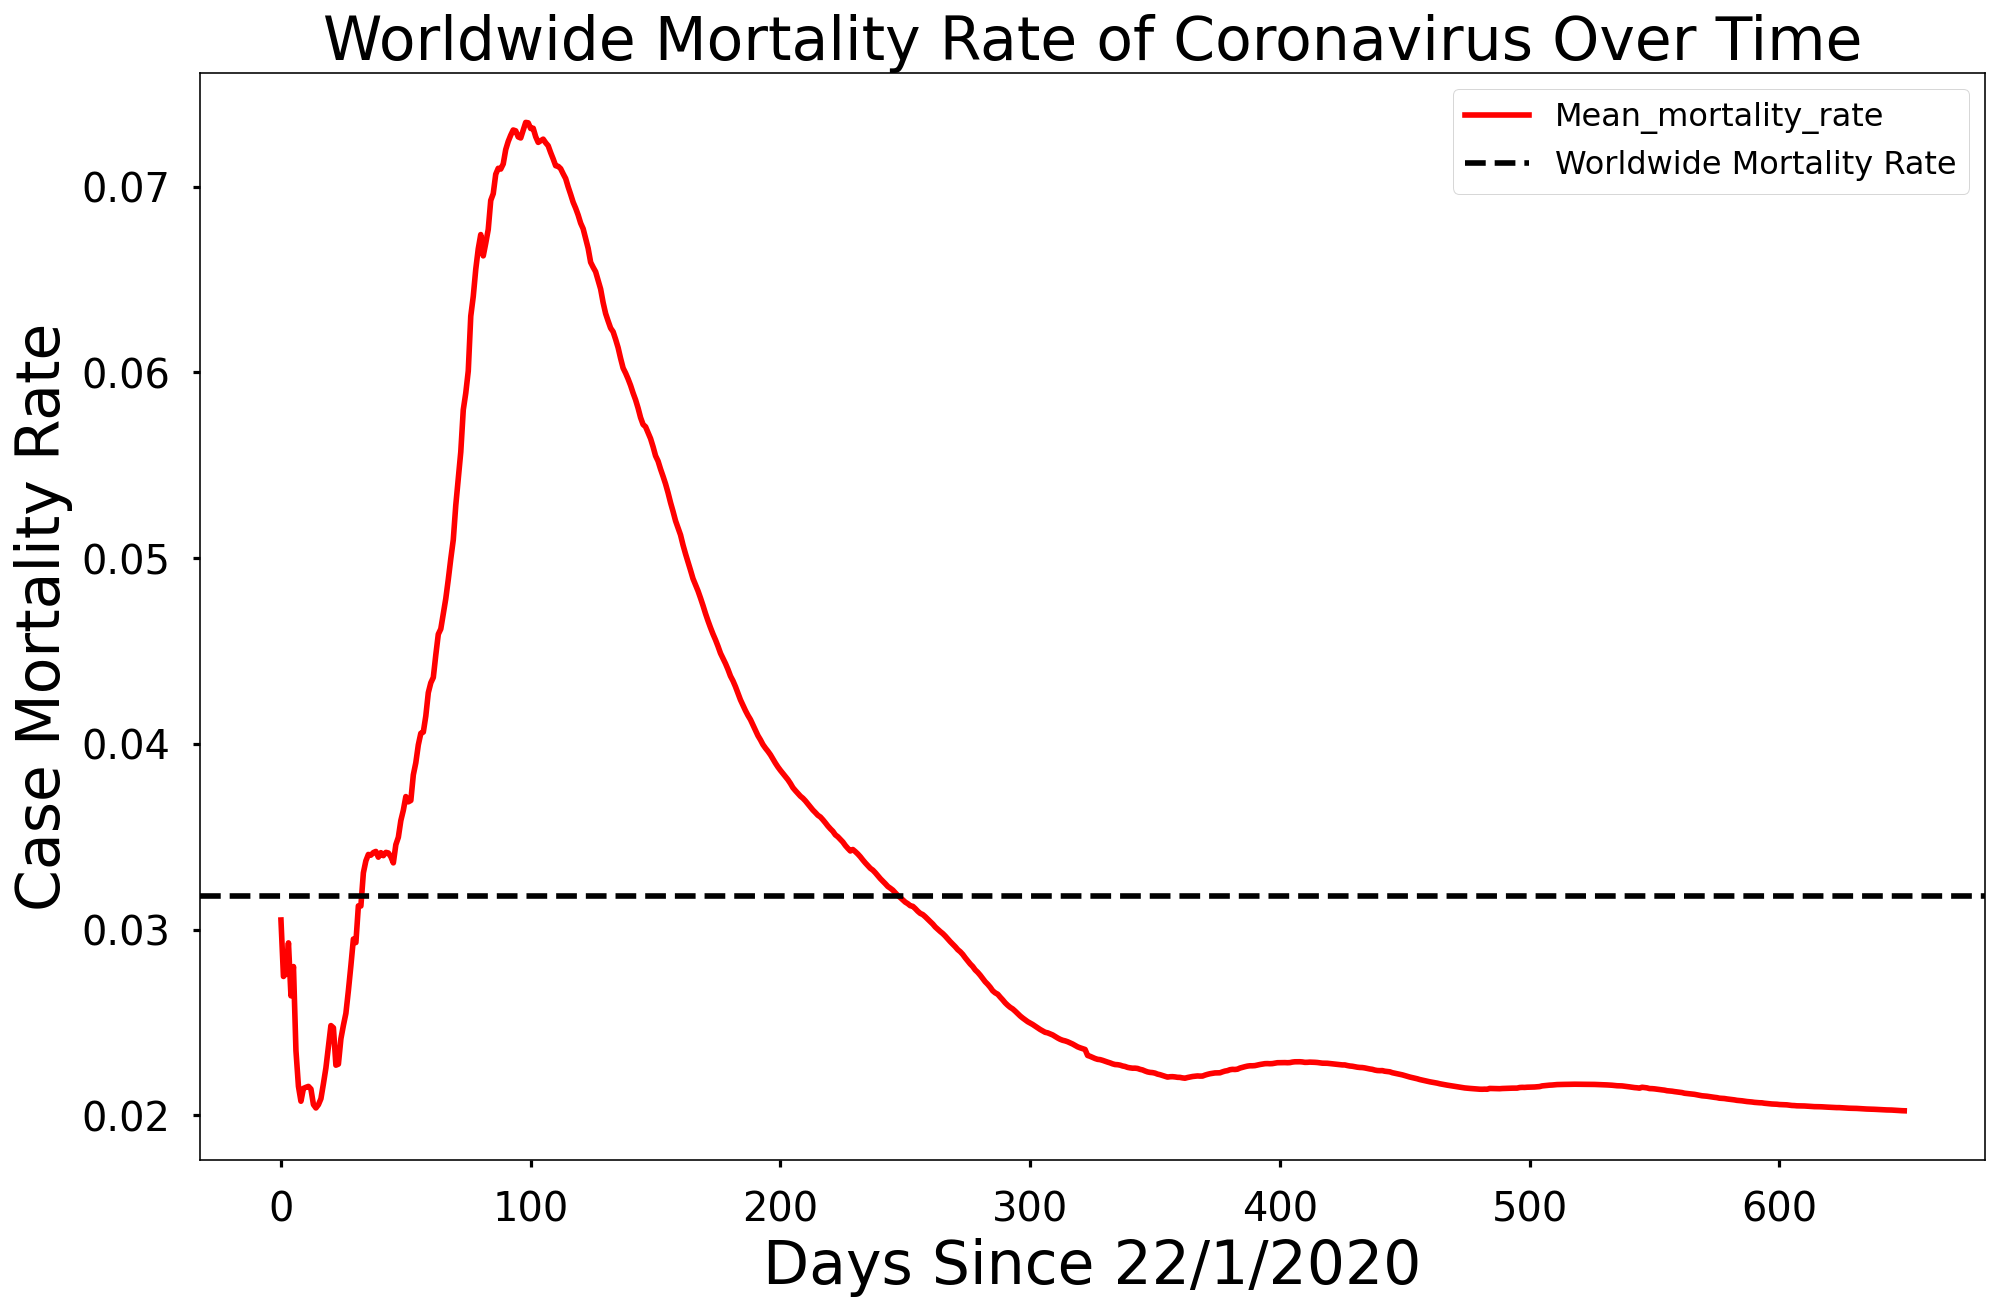

In [21]:
mean_mortality_rate = np.mean(mortality_rate)
plt.figure(figsize=(16, 10))
plt.plot(num_of_days, mortality_rate, color='red')
plt.axhline(y = mean_mortality_rate, linestyle='--', color='black')
plt.title('Worldwide Mortality Rate of Coronavirus Over Time', size=30)
plt.xlabel('Days Since 22/1/2020', size=30)
plt.ylabel('Case Mortality Rate', size=30)
plt.legend(['Mean_mortality_rate', 'Worldwide Mortality Rate'])
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [22]:
unique_provinces =  list(latest_data['Province_State'].unique())
province_confirmed_cases = []
province_country = [] 
province_death_cases = [] 
province_incidence_rate = []
province_mortality_rate = [] 

no_cases = [] 
for i in unique_provinces:
    cases = latest_data[latest_data['Province_State']==i]['Confirmed'].sum()
    if cases > 0:
        province_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
 
# remove areas with no confirmed cases
for i in no_cases:
    unique_provinces.remove(i)
    
unique_provinces = [k for k, v in sorted(zip(unique_provinces, province_confirmed_cases), key=operator.itemgetter(1), reverse=True)]
for i in range(len(unique_provinces)):
    province_confirmed_cases[i] = latest_data[latest_data['Province_State']==unique_provinces[i]]['Confirmed'].sum()
    province_country.append(latest_data[latest_data['Province_State']==unique_provinces[i]]['Country_Region'].unique()[0])
    province_death_cases.append(latest_data[latest_data['Province_State']==unique_provinces[i]]['Deaths'].sum())
    province_incidence_rate.append(latest_data[latest_data['Province_State']==unique_provinces[i]]['Incident_Rate'].sum())
    province_mortality_rate.append(province_death_cases[i]/province_confirmed_cases[i])

In [23]:
# number of cases per province/state/city top 100 
province_limit = 100 
province_df = pd.DataFrame({'Province/State Name': unique_provinces[:province_limit], 'Country': province_country[:province_limit], 'Number of Confirmed Cases': [format(int(i), ',d') for i in province_confirmed_cases[:province_limit]],
                          'Number of Deaths': [format(int(i), ',d') for i in province_death_cases[:province_limit]], 
                        'Incidence Rate' : province_incidence_rate[:province_limit], 'Mortality Rate': province_mortality_rate[:province_limit]})
# number of cases per country/region

province_df.style.background_gradient(cmap='Oranges')

,Province/State Name,Country,Number of Confirmed Cases,Number of Deaths,Incidence Rate,Mortality Rate
0,England,United Kingdom,"7,669,614","122,555",13701.317679,0.015979
1,Maharashtra,India,"6,609,906","140,196",5367.613550,0.021210
2,Kerala,India,"4,961,490","31,514",13897.947932,0.006352
3,California,US,"4,914,732","71,941",686335.470548,0.014638
4,Sao Paulo,Brazil,"4,405,527","151,975",9594.116376,0.034496
5,Texas,US,"4,238,040","71,139",3861752.477281,0.016786
6,Florida,US,"3,690,812","59,670",1153842.064290,0.016167
7,Karnataka,India,"2,988,041","38,071",4422.620202,0.012741
8,Tamil Nadu,India,"2,701,614","36,097",3470.670641,0.013361
9,New York,US,"2,556,628","56,413",686010.726361,0.022065


In [24]:
# return the data table with province/state info for a given country
def country_table(country_name):
    states = list(latest_data[latest_data['Country_Region']==country_name]['Province_State'].unique())
    state_confirmed_cases = []
    state_death_cases = [] 
    state_incidence_rate = [] 
    state_mortality_rate = [] 

    no_cases = [] 
    for i in states:
        cases = latest_data[latest_data['Province_State']==i]['Confirmed'].sum()
        if cases > 0:
            state_confirmed_cases.append(cases)
        else:
            no_cases.append(i)

    # remove areas with no confirmed cases
    for i in no_cases:
        states.remove(i)

    states = [k for k, v in sorted(zip(states, state_confirmed_cases), key=operator.itemgetter(1), reverse=True)]
    for i in range(len(states)):
        state_confirmed_cases[i] = latest_data[latest_data['Province_State']==states[i]]['Confirmed'].sum()
        state_death_cases.append(latest_data[latest_data['Province_State']==states[i]]['Deaths'].sum())
        state_incidence_rate.append(latest_data[latest_data['Province_State']==states[i]]['Incident_Rate'].sum())
        state_mortality_rate.append(state_death_cases[i]/state_confirmed_cases[i])
        
      
    state_df = pd.DataFrame({'State Name': states, 'Number of Confirmed Cases': [format(int(i), ',d') for i in state_confirmed_cases],
                              'Number of Deaths': [format(int(i), ',d') for i in state_death_cases], 
                             'Incidence Rate' : state_incidence_rate, 'Mortality Rate': state_mortality_rate})
    # number of cases per country/region
    return state_df

In [38]:
country_name = input('Input your country: ')
table = country_table(country_name)
table.style.background_gradient(cmap='Oranges')

,State Name,Number of Confirmed Cases,Number of Deaths,Incidence Rate,Mortality Rate
0,Sao Paulo,"4,405,527","151,975",9594.116376,0.034496
1,Minas Gerais,"2,184,868","55,552",10321.175168,0.025426
2,Parana,"1,553,985","40,503",13590.964178,0.026064
3,Rio Grande do Sul,"1,466,355","35,487",12888.496058,0.024201
4,Rio de Janeiro,"1,321,174","68,347",7652.350778,0.051732
5,Bahia,"1,246,064","27,076",8377.991246,0.021729
6,Santa Catarina,"1,216,323","19,656",16976.399023,0.016160
7,Ceara,"943,426","24,496",10330.901685,0.025965
8,Goias,"904,686","24,195",12890.287381,0.026744
9,Pernambuco,"631,632","20,007",6609.054176,0.031675


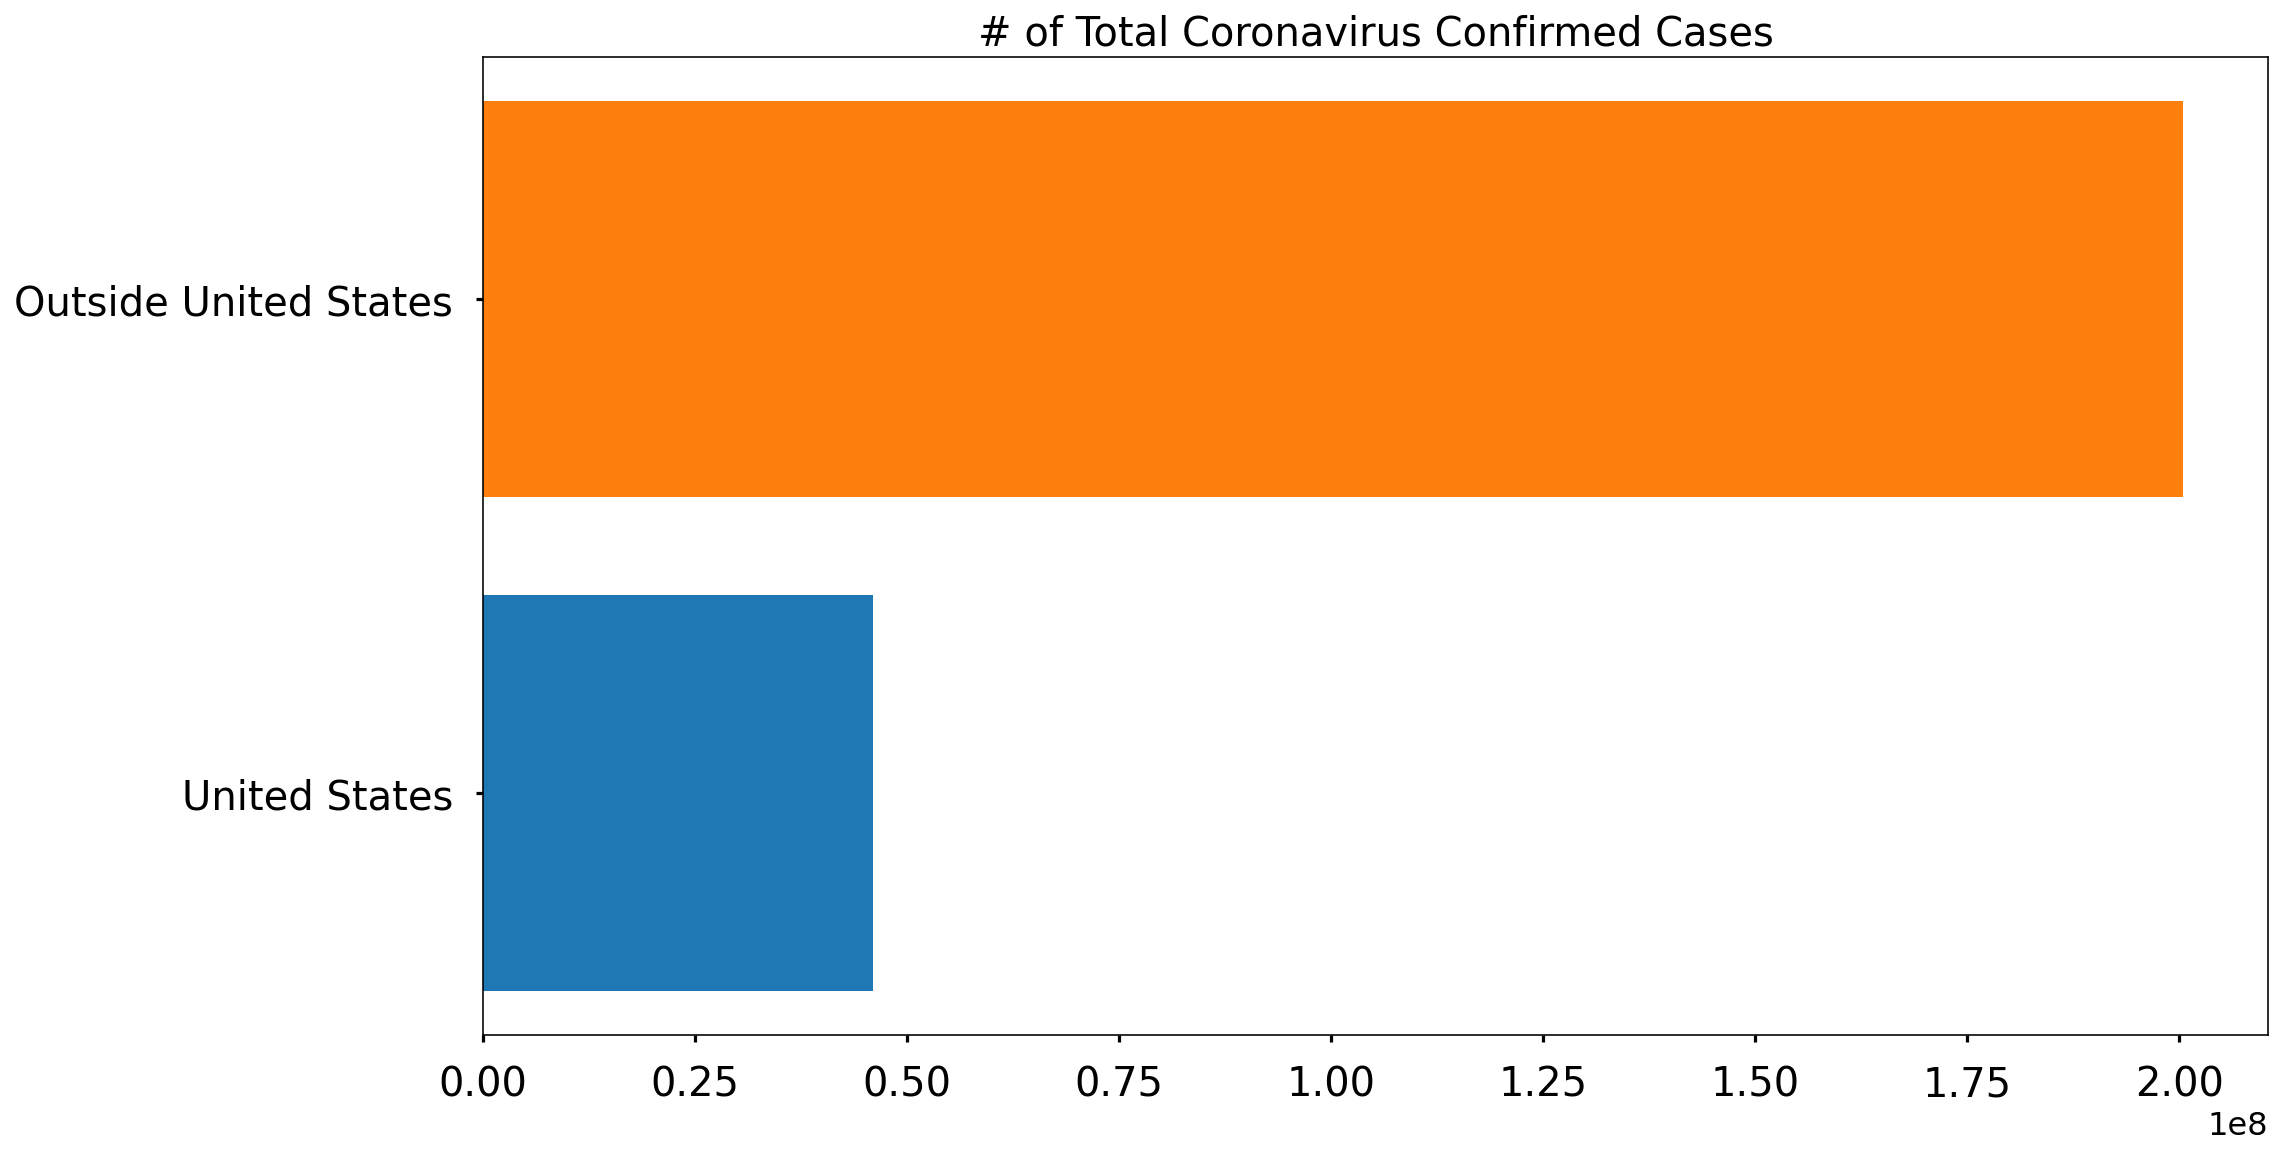

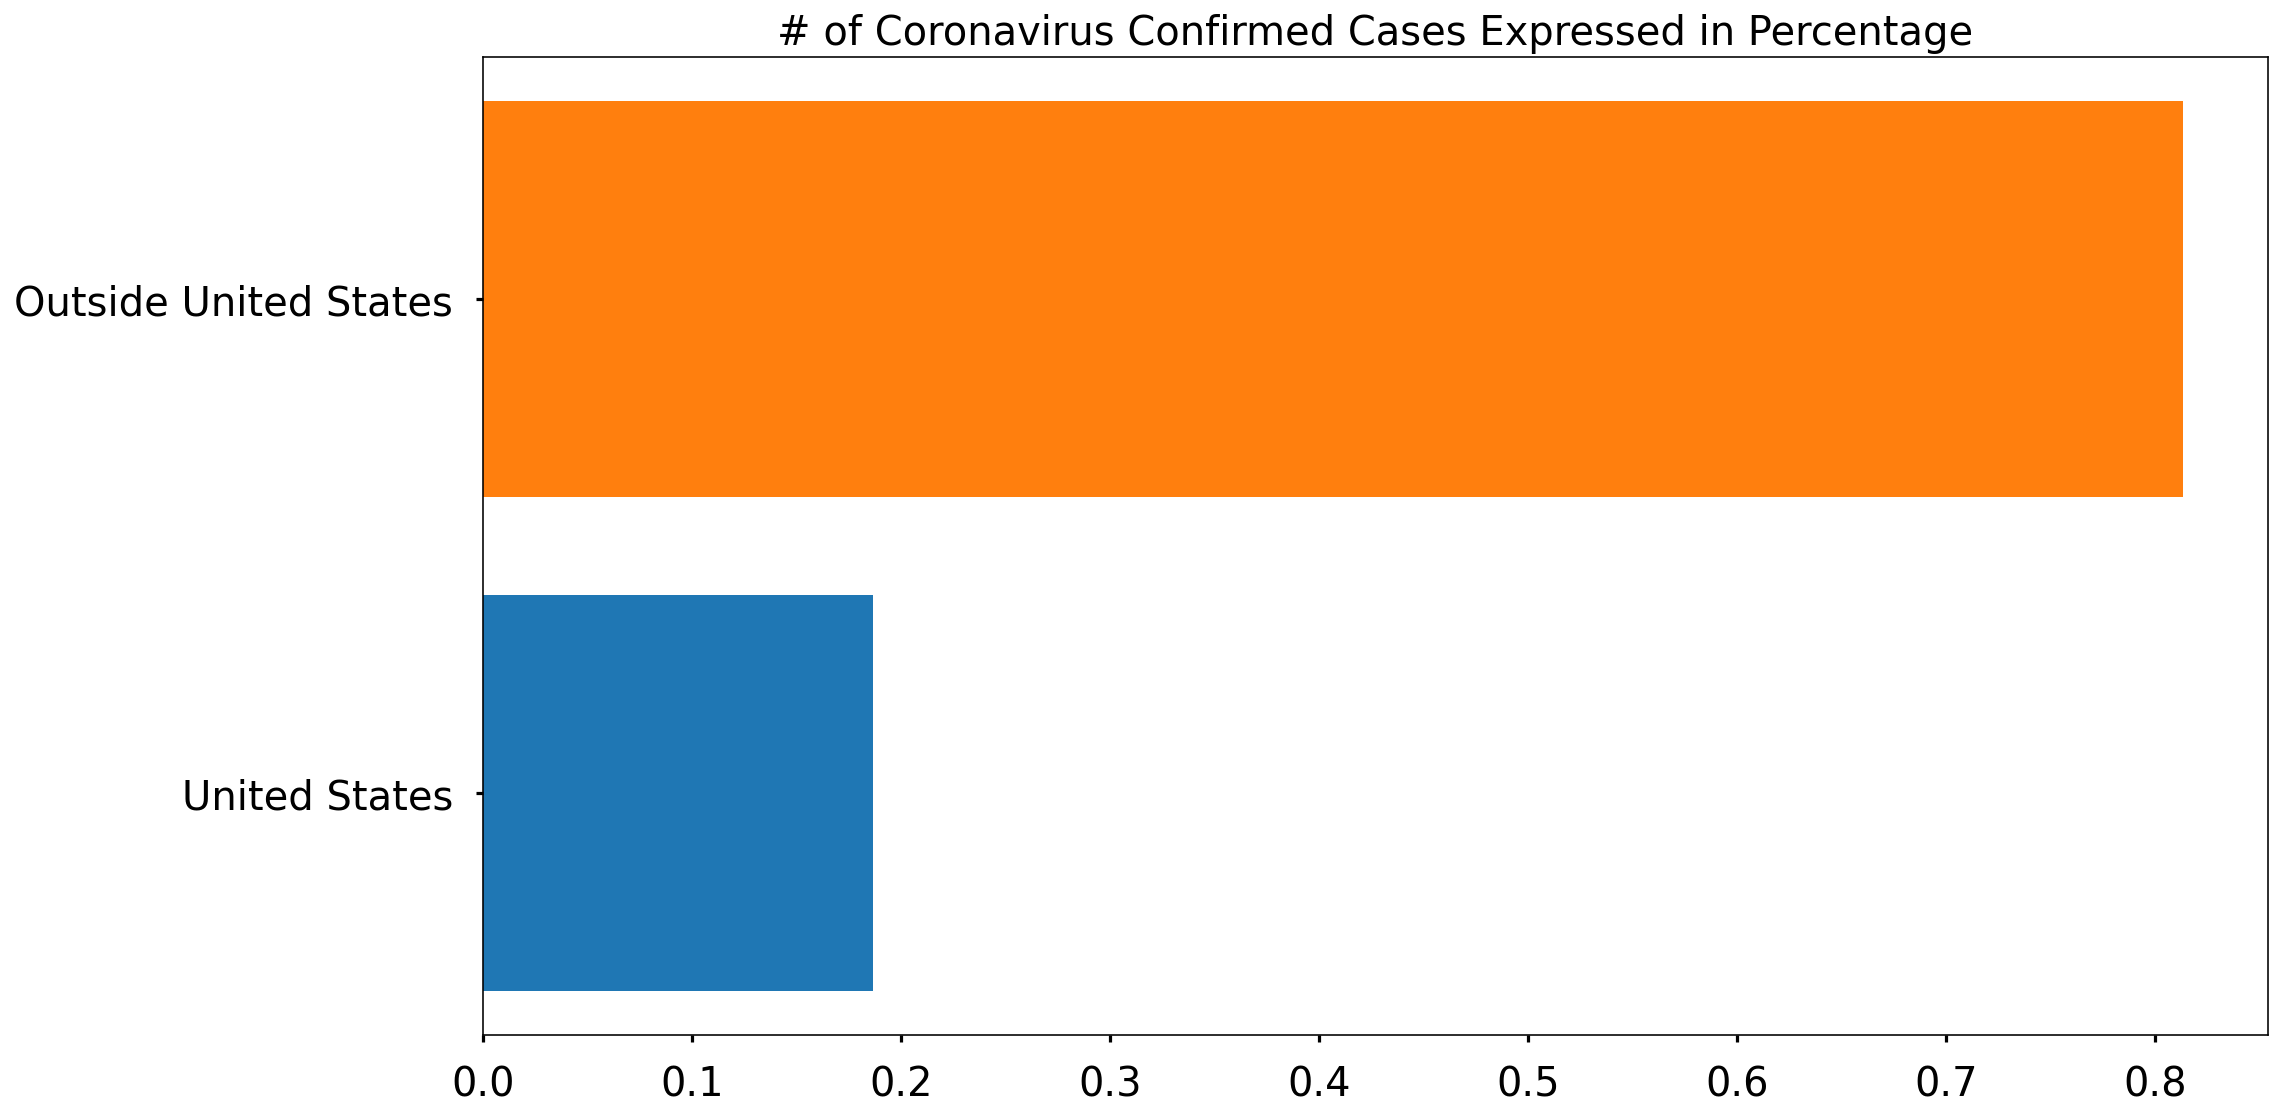

In [26]:
total_world_cases = np.sum(country_confirmed_cases)
us_confirmed = latest_data[latest_data['Country_Region']=='US']['Confirmed'].sum()
outside_us_confirmed = total_world_cases - us_confirmed

plt.figure(figsize=(16, 9))
plt.barh('United States', us_confirmed)
plt.barh('Outside United States', outside_us_confirmed)
plt.title('# of Total Coronavirus Confirmed Cases', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.barh('United States', us_confirmed/total_world_cases)
plt.barh('Outside United States', outside_us_confirmed/total_world_cases)
plt.title('# of Coronavirus Confirmed Cases Expressed in Percentage', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [27]:
print('Outside United States {} cases ({}%):'.format(outside_us_confirmed, np.round((outside_us_confirmed/total_world_cases)*100, 1)))
print('United States {} cases ({}%)'.format(us_confirmed, np.round((us_confirmed/total_world_cases)*100, 1)))
print('Total: {} cases'.format(total_world_cases))

Outside United States 200454065 cases (81.4%):
United States 45953186 cases (18.6%)
Total: 246407251 cases


In [28]:
# Only show 10 countries with the most confirmed cases, the rest are grouped into the other category
visual_unique_countries = [] 
visual_confirmed_cases = []
others = np.sum(country_confirmed_cases[10:])

for i in range(len(country_confirmed_cases[:10])):
    visual_unique_countries.append(unique_countries[i])
    visual_confirmed_cases.append(country_confirmed_cases[i])
    
visual_unique_countries.append('Others')
visual_confirmed_cases.append(others)

In [29]:
def plot_bar_graphs(x, y, title):
    plt.figure(figsize=PLOT_SIZE)
    plt.barh(x, y)
    plt.title(title, size=20)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

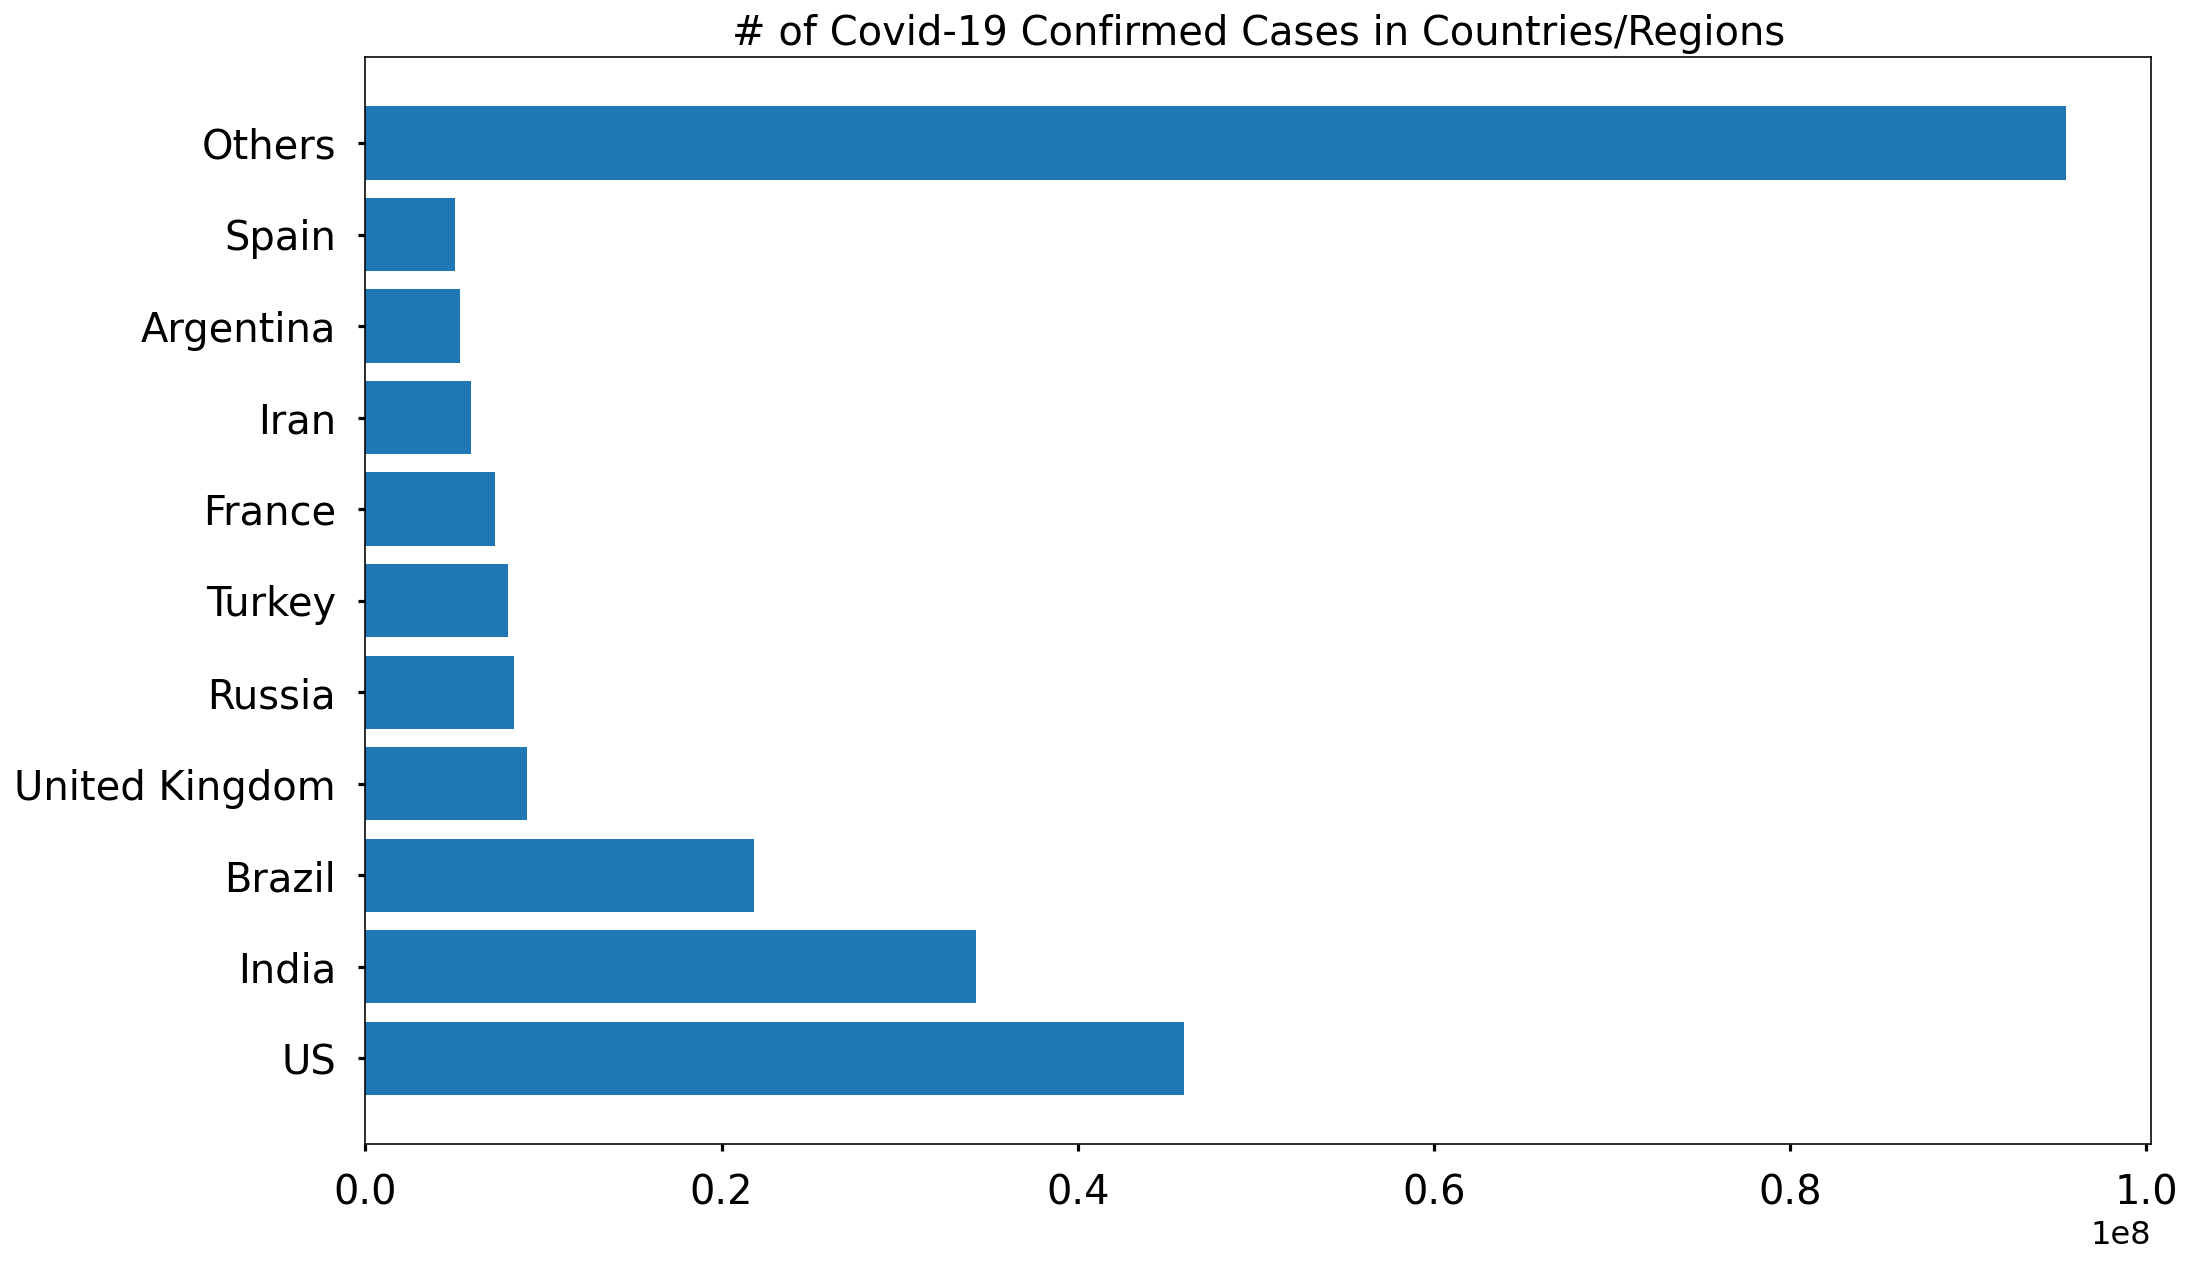

In [30]:
plot_bar_graphs(visual_unique_countries, visual_confirmed_cases, '# of Covid-19 Confirmed Cases in Countries/Regions')

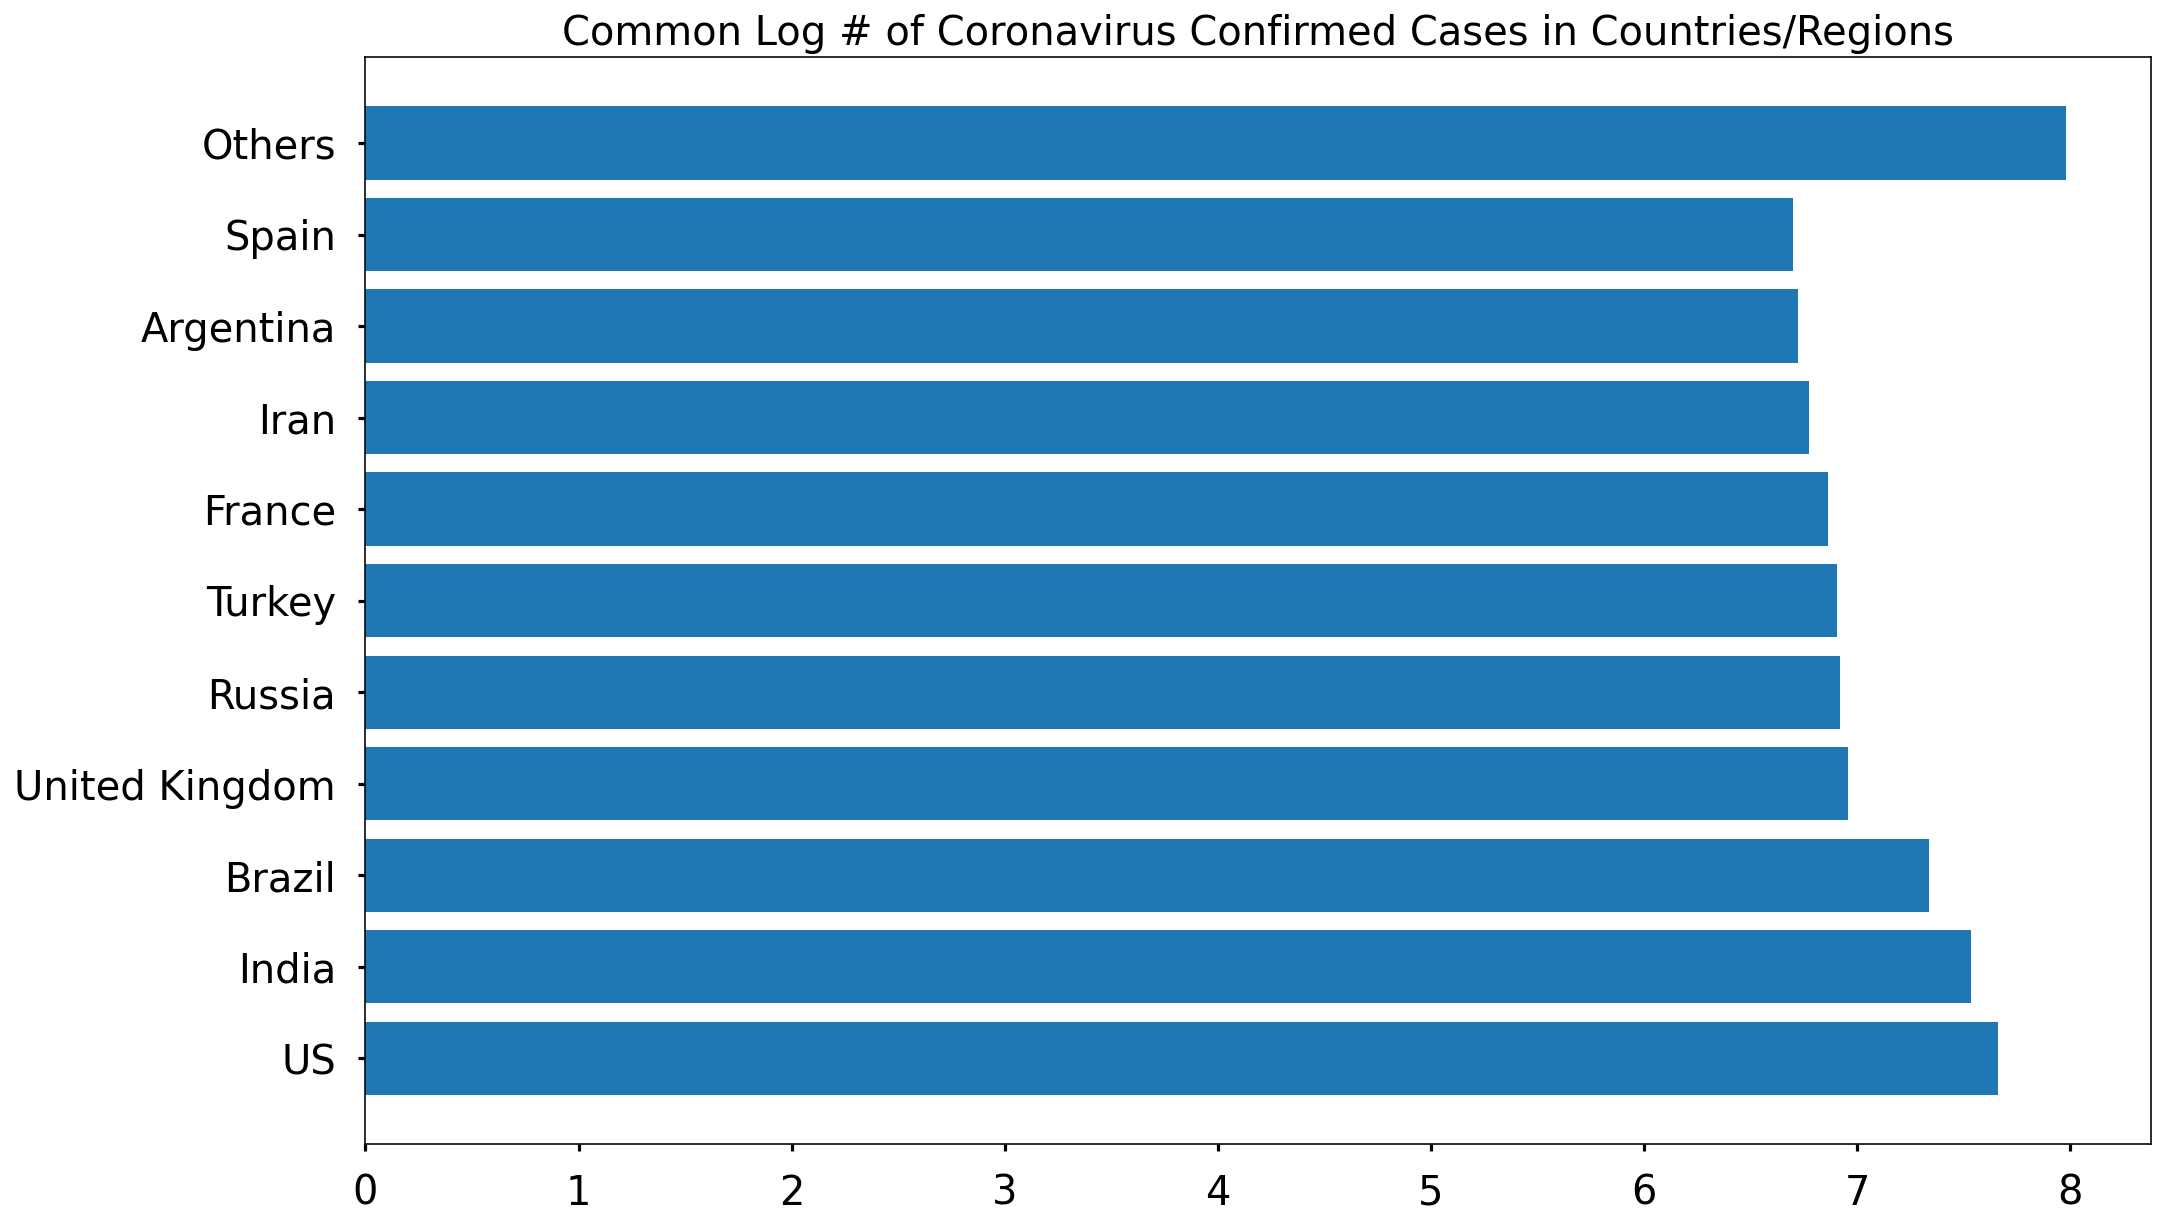

In [31]:
log_country_confirmed_cases = [math.log10(i) for i in visual_confirmed_cases]
plot_bar_graphs(visual_unique_countries, log_country_confirmed_cases, 'Common Log # of Coronavirus Confirmed Cases in Countries/Regions')

In [32]:
# Only show 10 provinces with the most confirmed cases, the rest are grouped into the other category
visual_unique_provinces = [] 
visual_confirmed_cases2 = []
others = np.sum(province_confirmed_cases[10:])
for i in range(len(province_confirmed_cases[:10])):
    visual_unique_provinces.append(unique_provinces[i])
    visual_confirmed_cases2.append(province_confirmed_cases[i])

visual_unique_provinces.append('Others')
visual_confirmed_cases2.append(others)

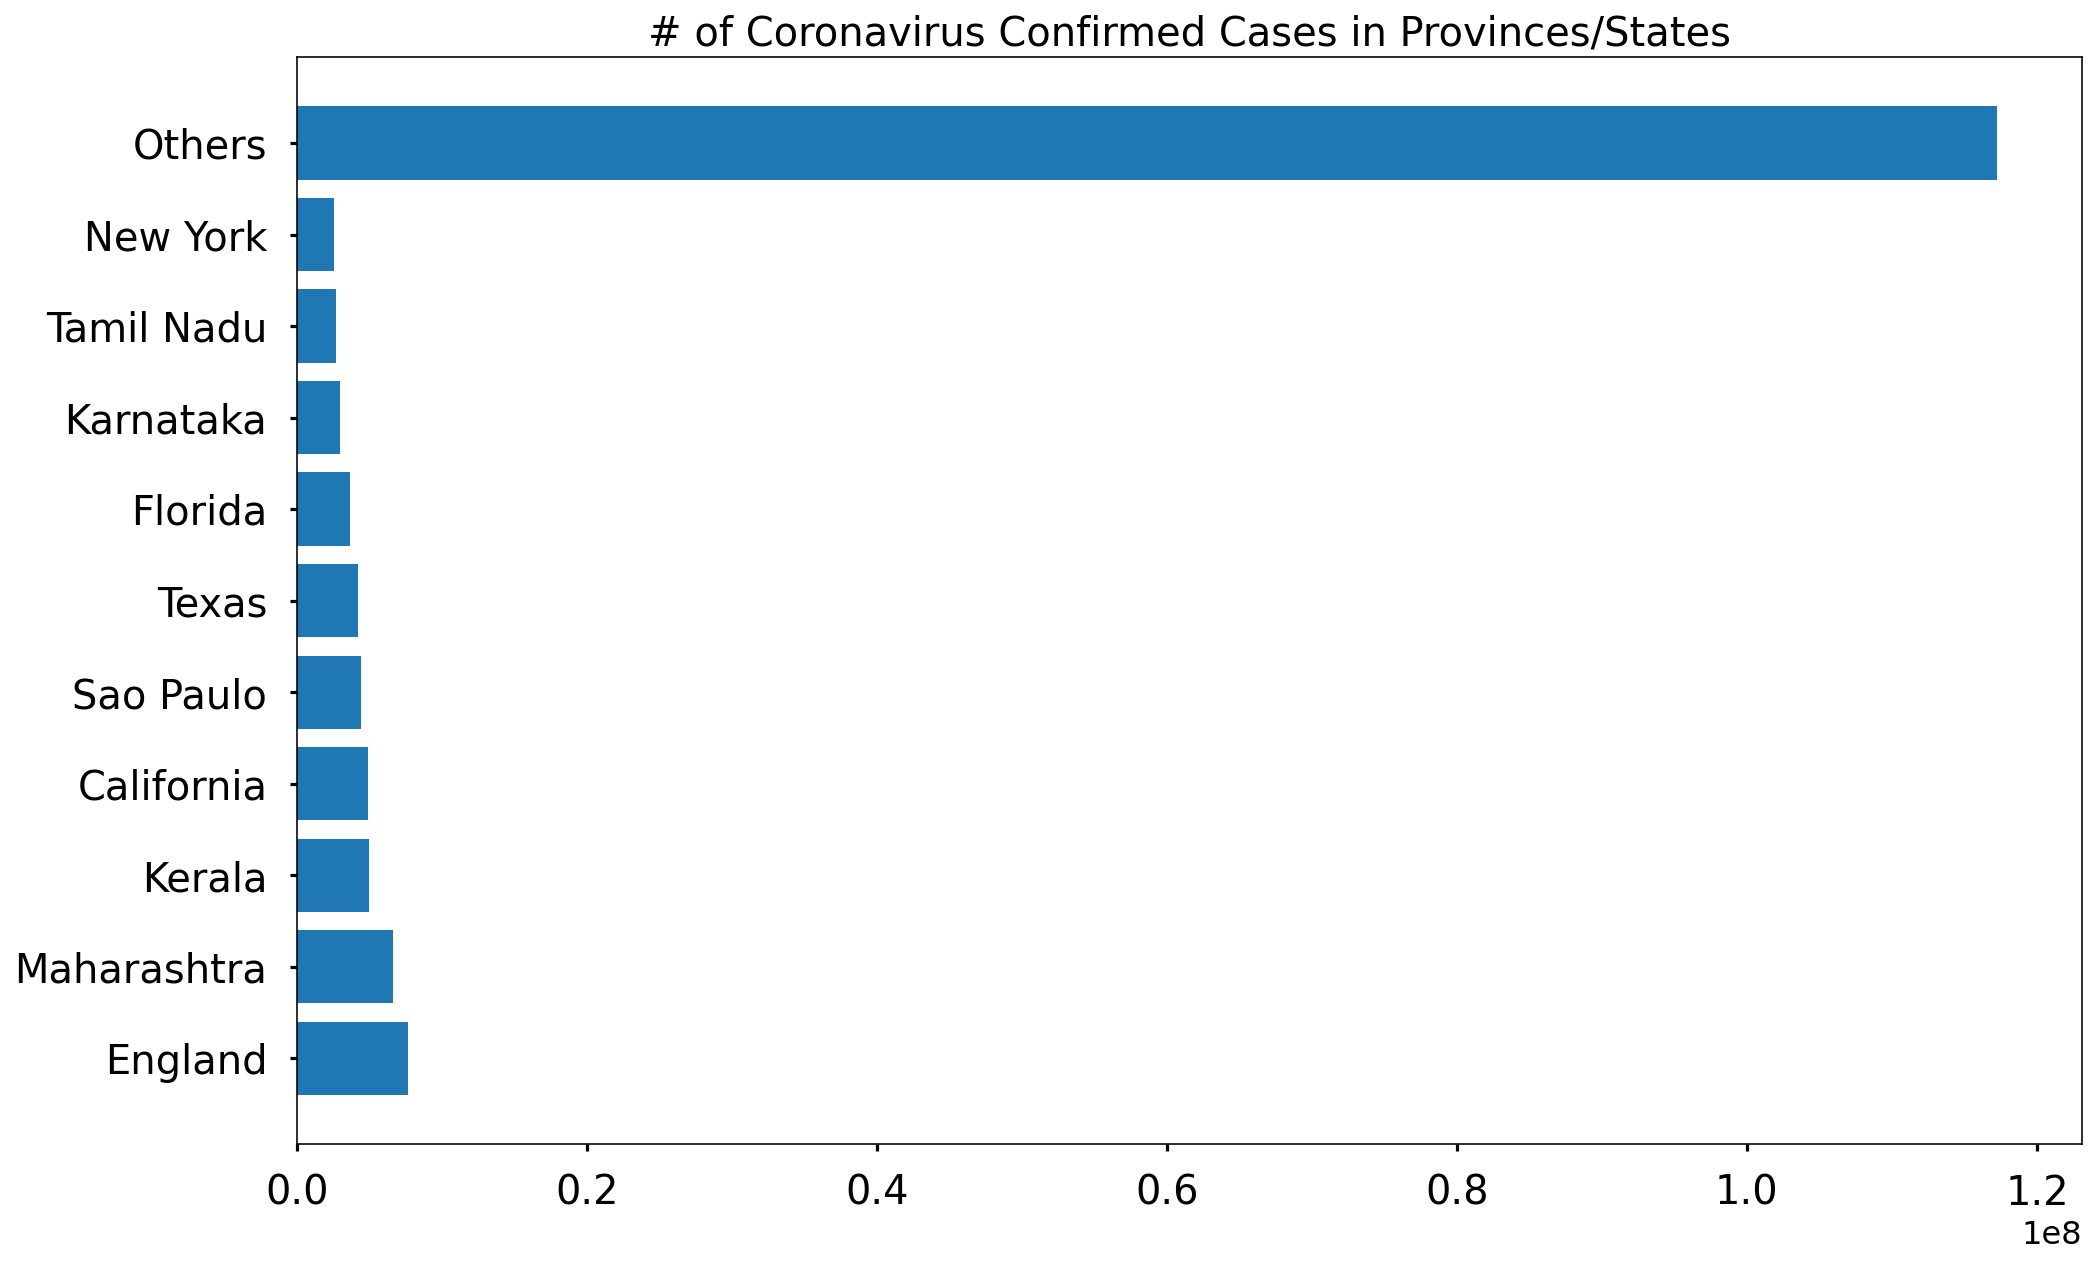

In [33]:
plot_bar_graphs(visual_unique_provinces, visual_confirmed_cases2, '# of Coronavirus Confirmed Cases in Provinces/States')

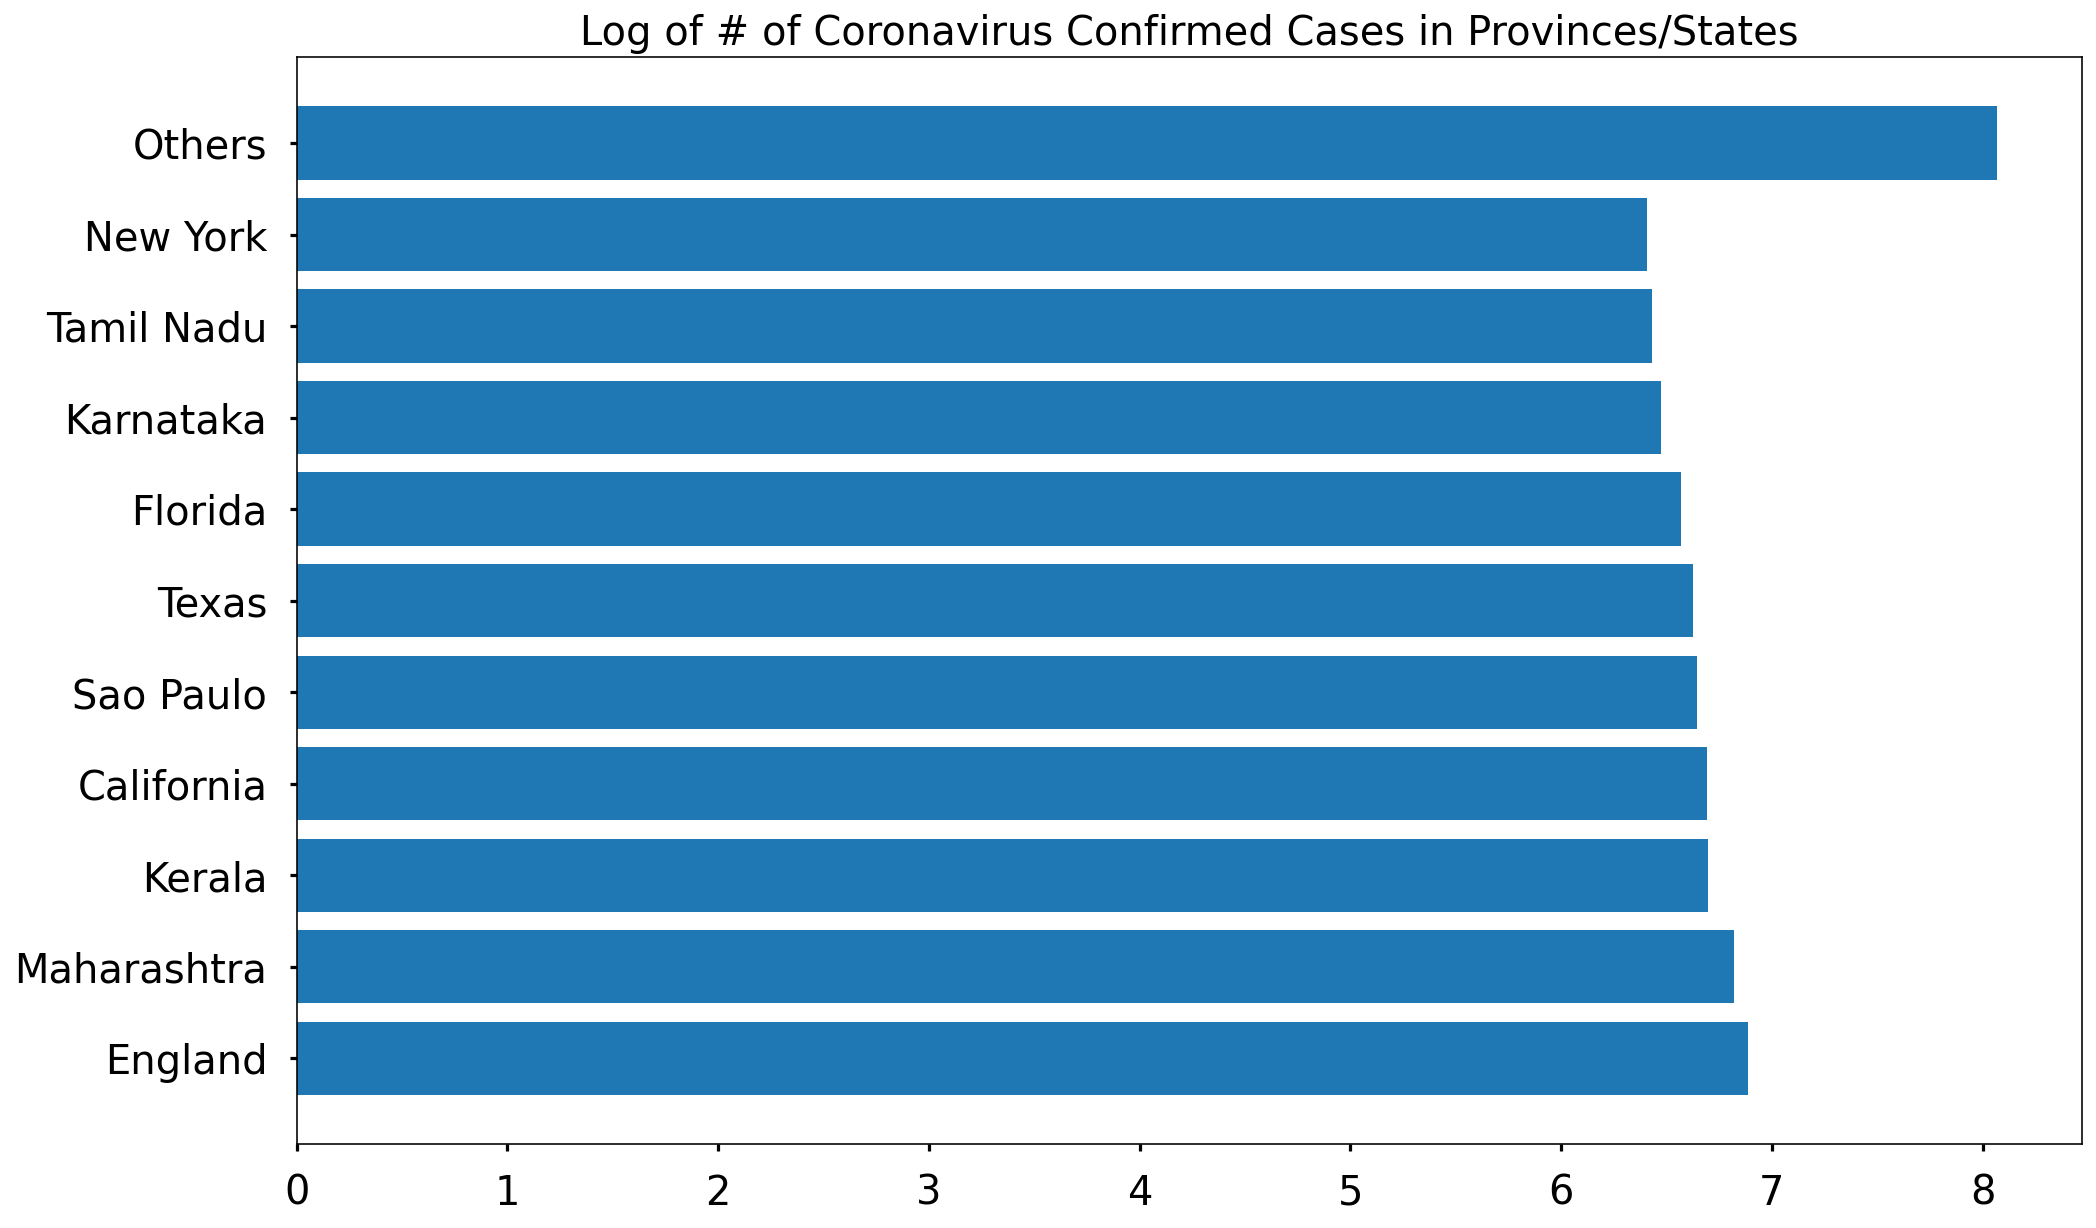

In [34]:
log_province_confirmed_cases = [math.log10(i) for i in visual_confirmed_cases2]
plot_bar_graphs(visual_unique_provinces, log_province_confirmed_cases, 'Log of # of Coronavirus Confirmed Cases in Provinces/States')

In [43]:
def plot_pie_charts(x, y, title):
    # more muted color 
    c = ['lightcoral', 'rosybrown', 'sandybrown', 'navajowhite', 'gold',
        'khaki', 'lightskyblue', 'turquoise', 'lightslategrey', 'thistle', 'pink']
    plt.figure(figsize=(20,15))
    plt.title(title, size=20)
    plt.pie(y, colors=c,shadow=True)
    plt.legend(x, loc='best', fontsize=12)
    plt.show()

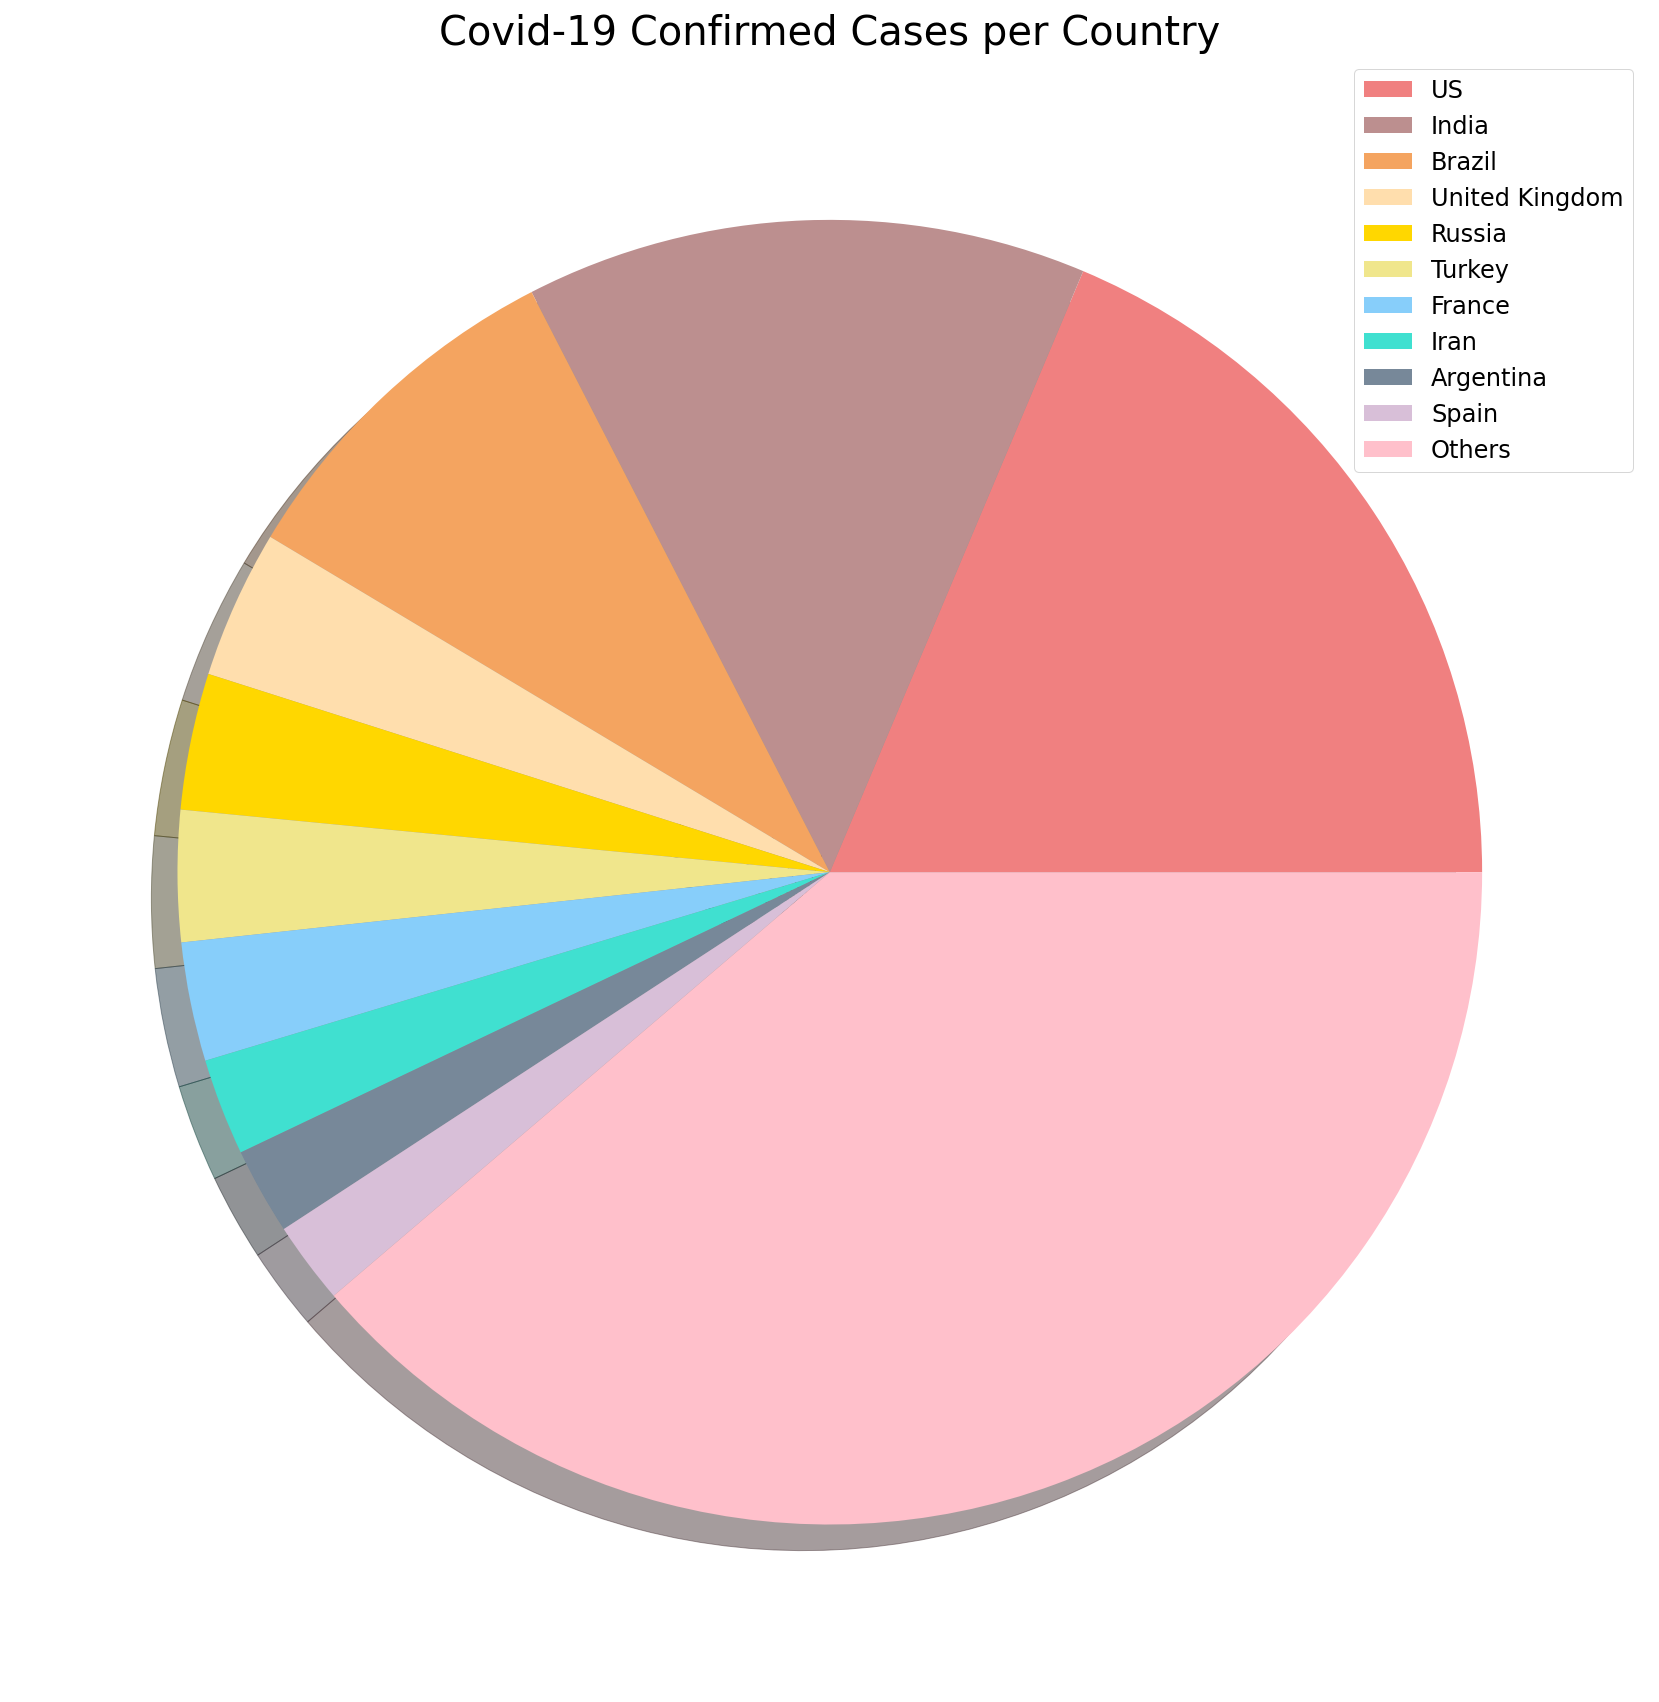

In [44]:
plot_pie_charts(visual_unique_countries, visual_confirmed_cases, 'Covid-19 Confirmed Cases per Country')

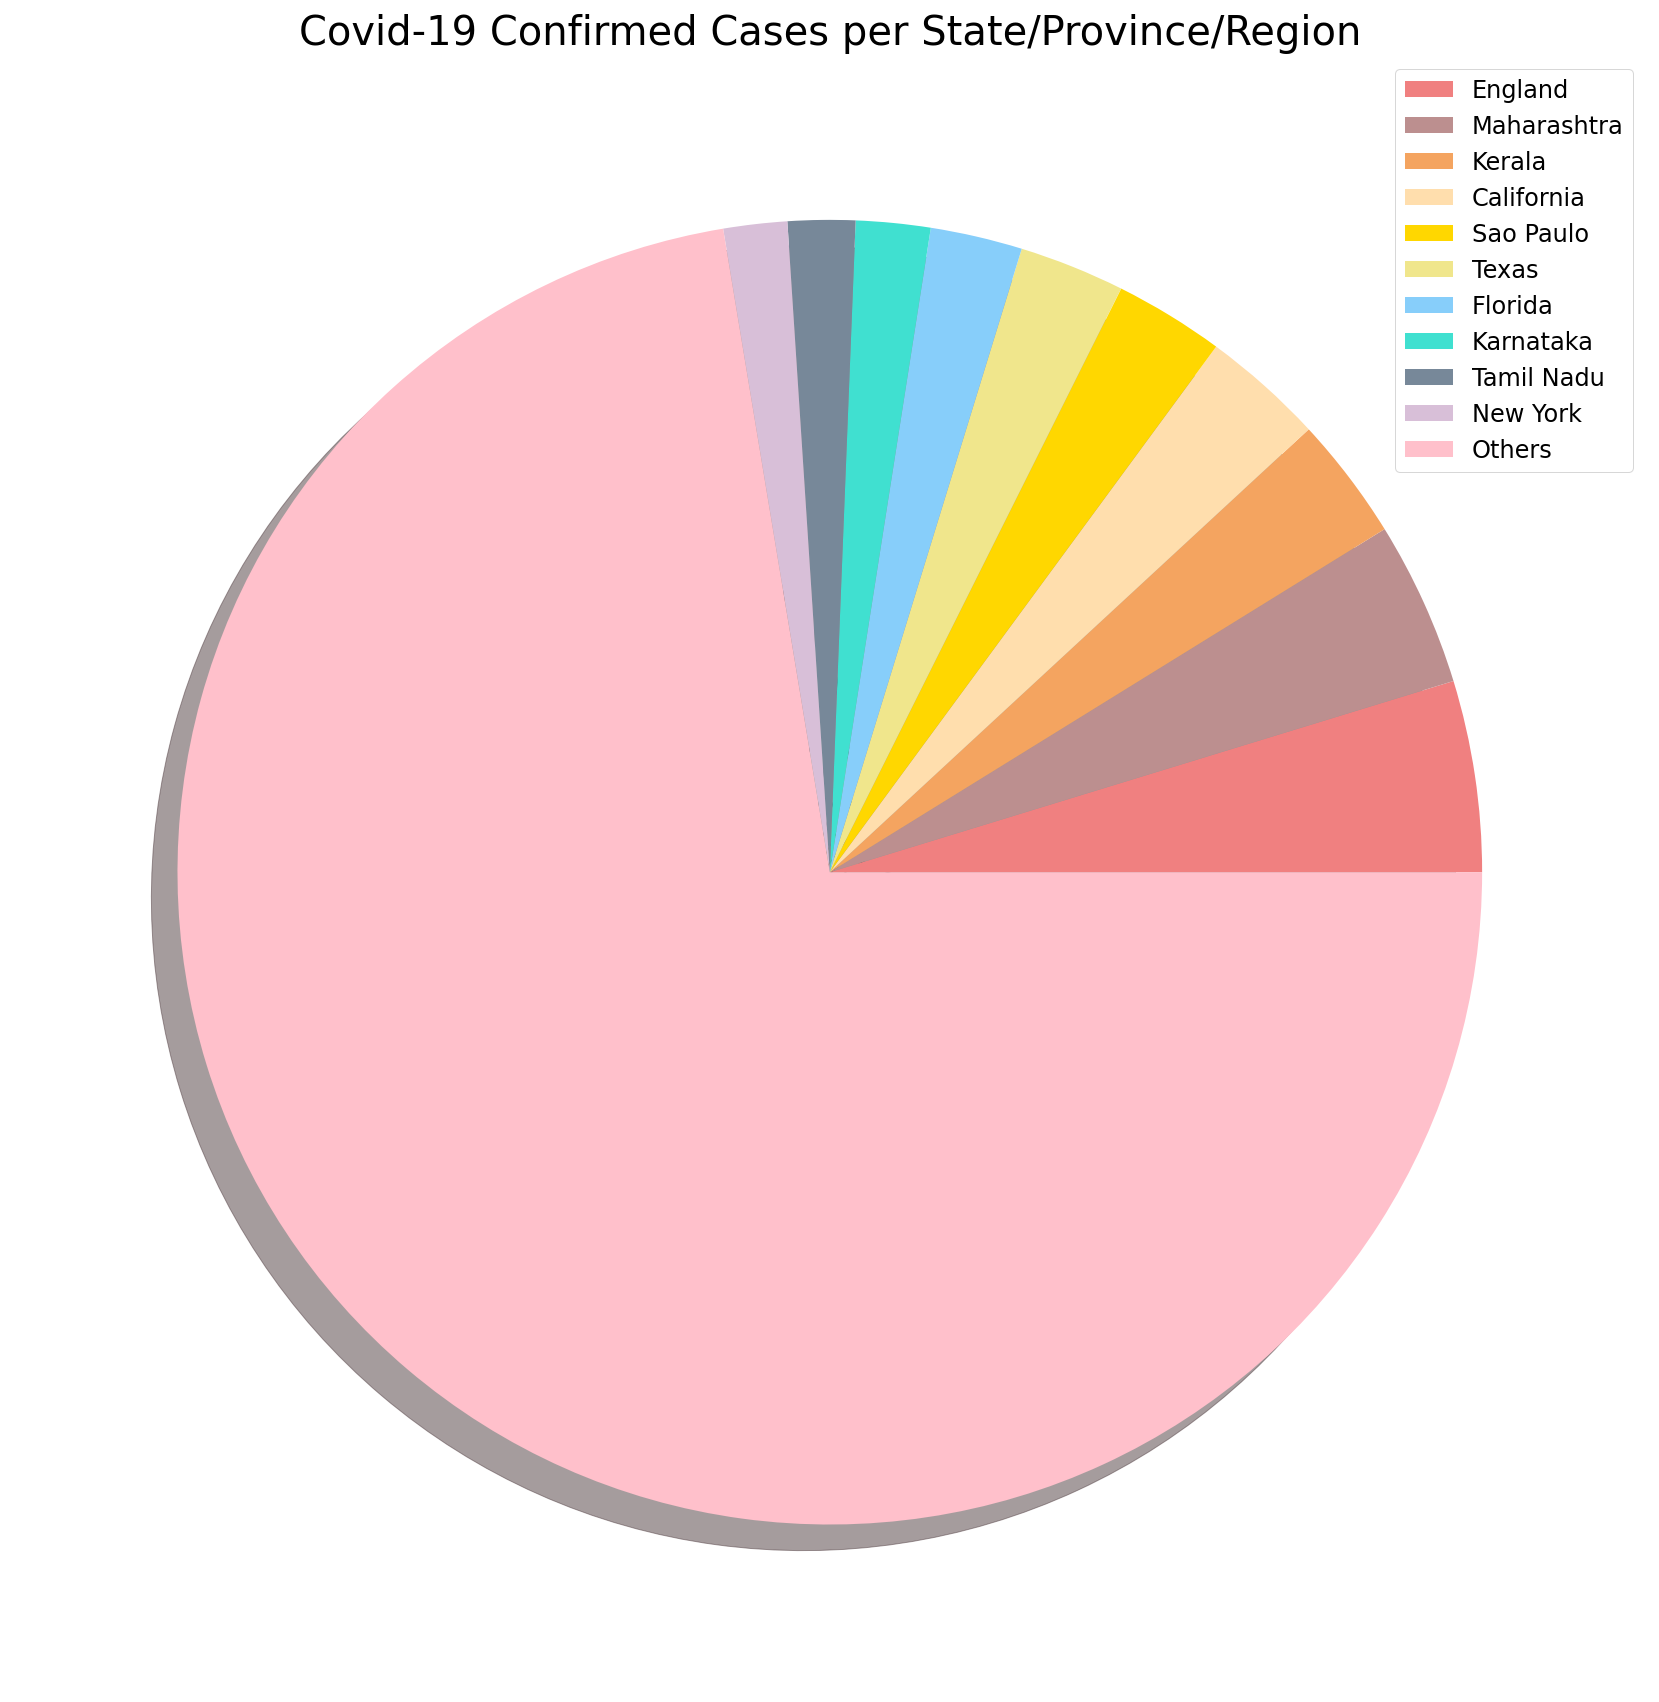

In [39]:
plot_pie_charts(visual_unique_provinces, visual_confirmed_cases2, 'Covid-19 Confirmed Cases per State/Province/Region')

In [45]:
# Plotting countries with regional data using a pie chart 
def plot_pie_country_with_regions(country_name, title):
    regions = list(latest_data[latest_data['Country_Region']==country_name]['Province_State'].unique())
    confirmed_cases = []
    no_cases = [] 
    for i in regions:
        cases = latest_data[latest_data['Province_State']==i]['Confirmed'].sum()
        if cases > 0:
            confirmed_cases.append(cases)
        else:
            no_cases.append(i)

    # remove areas with no confirmed cases
    for i in no_cases:
        regions.remove(i)

    # only show the top 5 states
    regions = [k for k, v in sorted(zip(regions, confirmed_cases), key=operator.itemgetter(1), reverse=True)]

    for i in range(len(regions)):
        confirmed_cases[i] = latest_data[latest_data['Province_State']==regions[i]]['Confirmed'].sum()  
    
    # additional province/state will be considered "others"    
    if(len(regions)>5):
        regions_5 = regions[:5]
        regions_5.append('Others')
        confirmed_cases_5 = confirmed_cases[:5]
        confirmed_cases_5.append(np.sum(confirmed_cases[5:]))
        plot_pie_charts(regions_5,confirmed_cases_5, title)
    else:
        plot_pie_charts(regions,confirmed_cases, title)

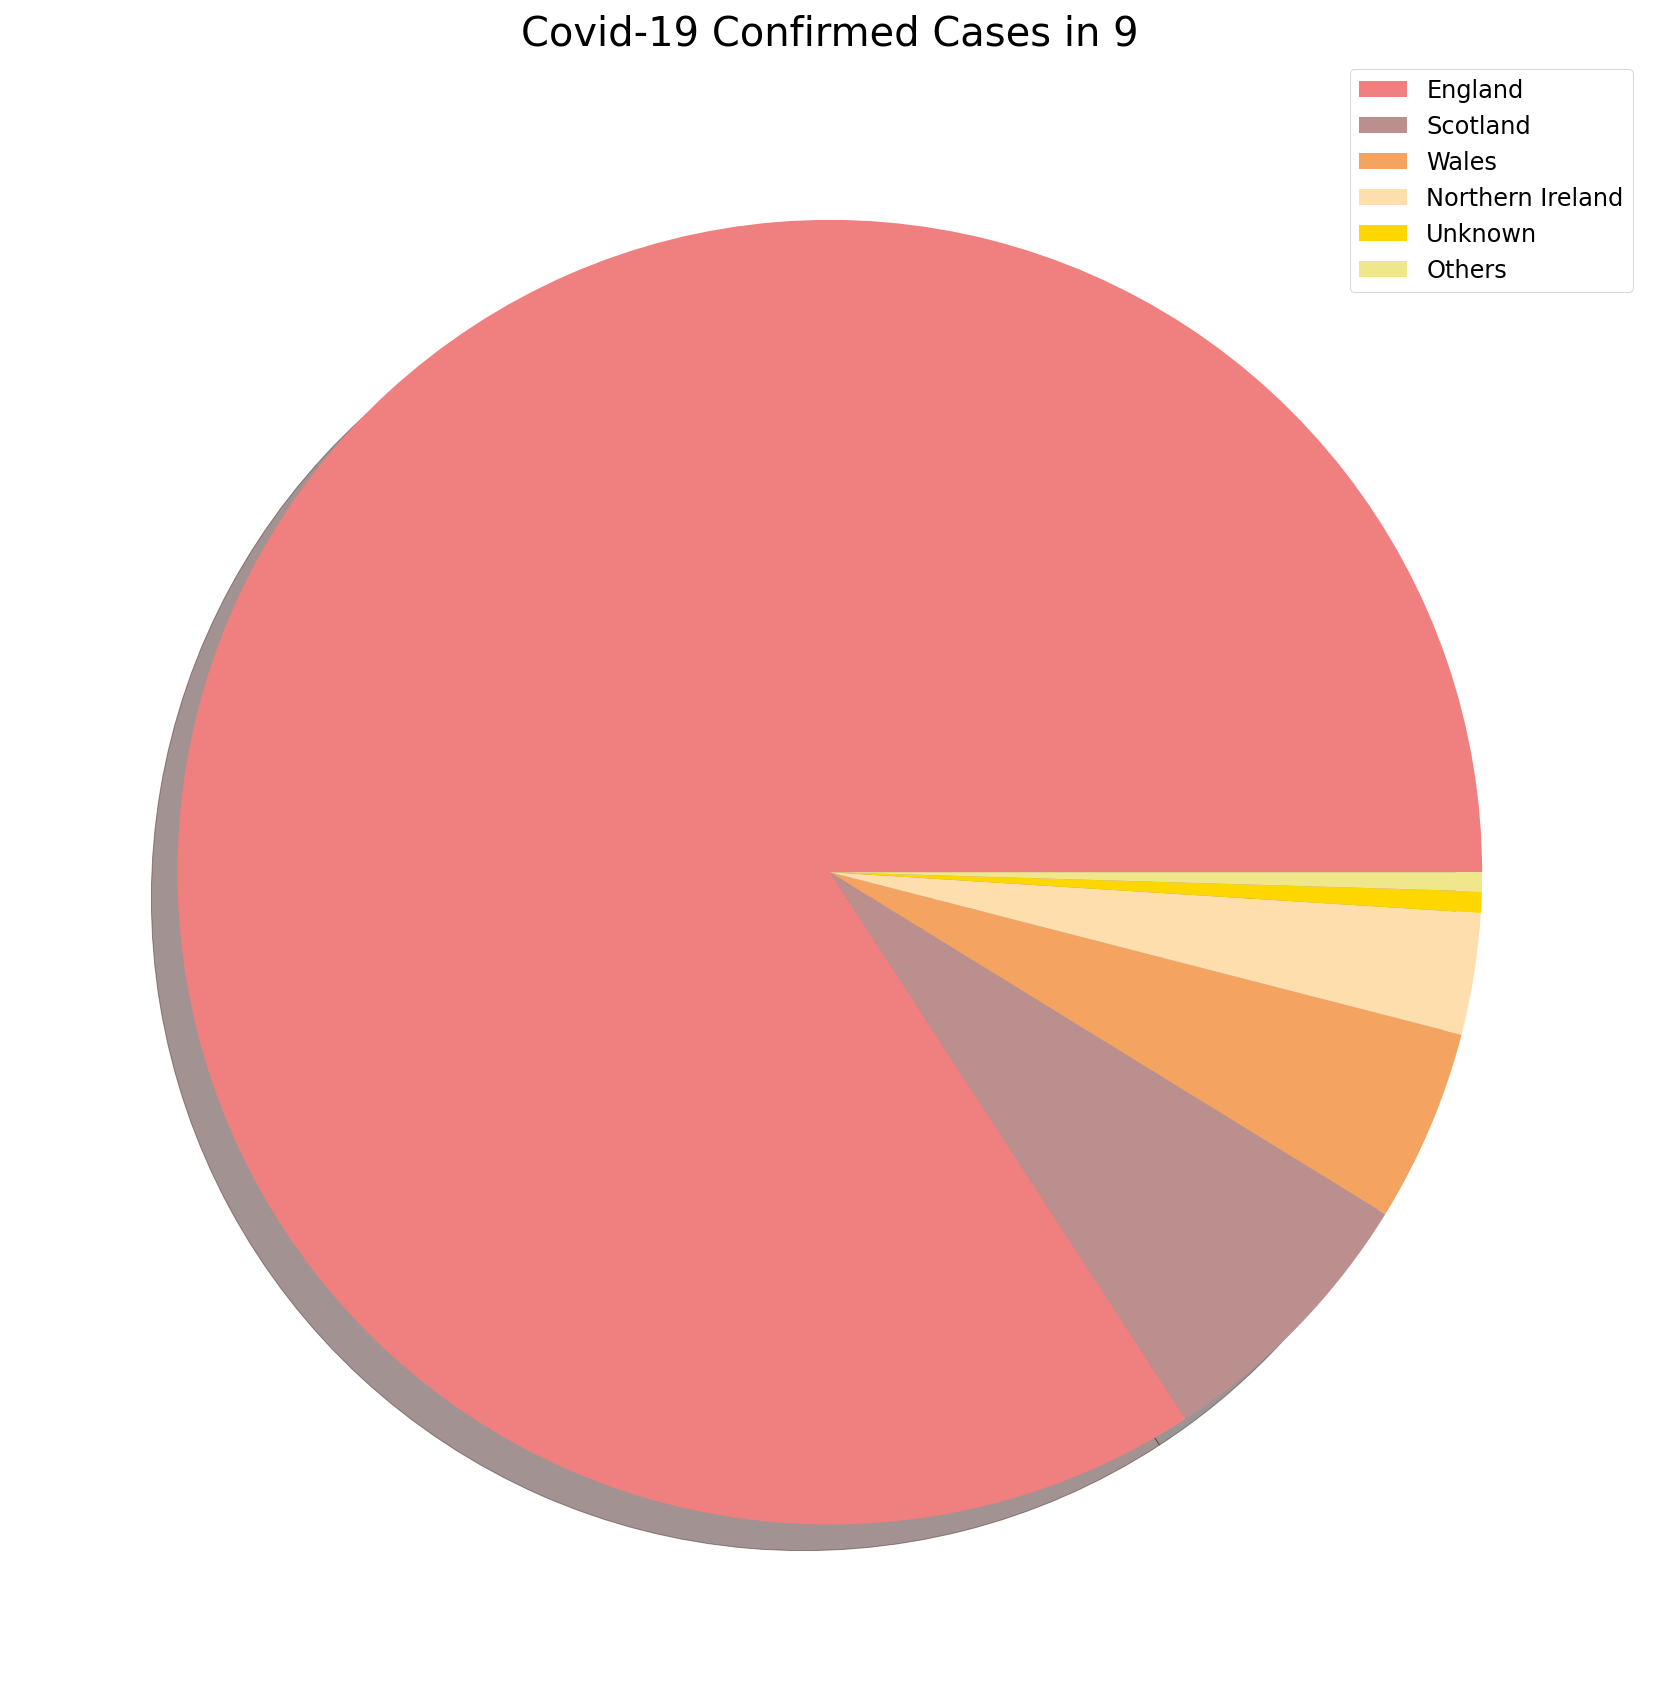

In [49]:
country_name = input('Input the country name: ')
plot_pie_country_with_regions(country_name, 'Covid-19 Confirmed Cases in {}'.format(i))

In [51]:
days_in_future = 10
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
start = '1/22/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

In [55]:
days_to_skip = 376
days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since_1_22[days_to_skip:], world_cases[days_to_skip:], test_size=0.08, shuffle=False) 

In [58]:
svm_confirmed = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=3, C=0.1)
svm_confirmed.fit(X_train_confirmed, y_train_confirmed)
svm_pred = svm_confirmed.predict(future_forcast)

In [60]:
len(svm_pred)

661